In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **LOADING THE READING THE RAW DATA**

In [ ]:
# @title
import pandas as pd

# Replace 'your_folder/your_file.csv' with the actual path to your file in Google Drive
file_path = '/content/drive/MyDrive/SIH_Data_PS-08/DATA_MEO_Train.csv'
try:
  df = pd.read_csv(file_path)
  print("File read successfully!")
  # Display the first few rows of the dataframe
  display(df.head())
except FileNotFoundError:
  print(f"Error: The file was not found at '{file_path}'. Please check the path and try again.")
except Exception as e:
  print(f"An error occurred: {e}")


File read successfully!


,utc_time,x_error (m),y_error (m),z_error (m),satclockerror (m)
0,9/1/2025 14:00,-0.765883,0.671544,0.434251,-0.183989
1,9/1/2025 15:00,-0.568186,0.392191,0.637844,-0.159422
2,9/1/2025 16:00,-0.535862,0.174319,0.723323,0.035761
3,9/1/2025 17:00,-0.641200,-0.205229,0.718195,-0.077574
4,9/1/2025 18:00,-0.638888,-0.396329,0.475825,0.161143


In [ ]:
# @title
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def verify_one_week_data(df):
    """
    Verify we have one complete week of MEO data for training
    """
    print("VERIFYING ONE WEEK OF MEO DATA")
    print("=" * 50)

    # Check date range
    start_date = df['utc_time'].min().date()
    end_date = df['utc_time'].max().date()
    total_days = (end_date - start_date).days + 1

    print(f"Date range: {start_date} to {end_date}")
    print(f"Total days: {total_days} days")

    # Check data distribution by day
    df['date'] = df['utc_time'].dt.date
    daily_counts = df['date'].value_counts().sort_index()

    print(f"\n DAILY DATA DISTRIBUTION:")
    for date, count in daily_counts.items():
        print(f"  {date}: {count:3d} readings")

    # Check if we have all 7 days
    if total_days == 7:
        print(f"\n PERFECT! Found exactly 7 days of data")
        print(f"   Using ALL data for training (Days 1-7)")
        print(f"   Will predict Day 8")
    elif total_days > 7:
        print(f"\n  Found {total_days} days, but expected 7")
        print(f"   Using first 7 days for training")
        # Filter to first 7 days
        seventh_day = start_date + timedelta(days=6)
        df = df[df['utc_time'].dt.date <= seventh_day]
    else:
        print(f"\n Only {total_days} days found - insufficient for 7-day training")
        return None

    return df

# Load and verify MEO data
print("Loading MEO data...")
geo_data = pd.read_csv('/content/drive/MyDrive/SIH_Data_PS-08/DATA_GEO_Train.csv')

# Convert datetime
geo_data['utc_time'] = pd.to_datetime(geo_data['utc_time'], errors='coerce')
geo_data = geo_data.dropna(subset=['utc_time'])

# Verify one week
geo_training = verify_one_week_data(geo_data)

if geo_training is not None:
    print(f"\nTRAINING DATA READY")
    print(f"   Final size: {len(geo_training)} rows")
    print(f"   Date range: {geo_training['utc_time'].min()} to {geo_training['utc_time'].max()}")

    # Show sample
    print(f"\n SAMPLE OF TRAINING DATA:")
    print(geo_training[['utc_time', 'x_error (m)', 'y_error (m)', 'z_error (m)', 'satclockerror (m)']].head())
else:
    print("Cannot proceed - insufficient data")

Loading MEO data...
VERIFYING ONE WEEK OF MEO DATA
Date range: 2025-09-01 to 2025-09-07
Total days: 7 days

 DAILY DATA DISTRIBUTION:
  2025-09-01:   9 readings
  2025-09-02:  12 readings
  2025-09-03:  33 readings
  2025-09-04:  12 readings
  2025-09-05:  12 readings
  2025-09-06:  11 readings
  2025-09-07:  53 readings

 PERFECT! Found exactly 7 days of data
   Using ALL data for training (Days 1-7)
   Will predict Day 8

TRAINING DATA READY
   Final size: 142 rows
   Date range: 2025-09-01 06:00:00 to 2025-09-07 23:41:00

 SAMPLE OF TRAINING DATA:
             utc_time  x_error (m)  y_error (m)  z_error (m)  \
0 2025-09-01 06:00:00     5.333443     4.530495    -2.600099   
1 2025-09-01 08:00:00     0.222901     0.177056    -0.008267   
2 2025-09-01 10:00:00     0.542796     1.124622     6.286751   
3 2025-09-01 12:00:00     0.164464     0.013855     0.007338   
4 2025-09-01 14:00:00    -0.838448    -0.667825     0.676121   

   satclockerror (m)  
0           1.280427  
1          -

# **PERPORCESSING AND CLEANING THE DATA**
*   Linear Agumentation
*   Handling NaN values
*   Removing outliers using boxplot






In [ ]:
# @title
import pandas as pd
import numpy as np
from scipy import interpolate

def simple_linear_augmentation(df):
    """
    Simple linear interpolation to create 15-minute data
    """
    print("SIMPLE LINEAR AUGMENTATION")
    print("=" * 50)

    df_clean = df.copy()

    # Clean column names
    df_clean = df_clean.rename(columns={
        'x_error (m)': 'x_error',
        'y_error (m)': 'y_error',
        'z_error (m)': 'z_error',
        'satclockerror (m)': 'clock_error'
    })

    # Convert to numeric timestamps
    df_clean['timestamp'] = (df_clean['utc_time'] - df_clean['utc_time'].min()).dt.total_seconds()

    # Create target 15-minute grid within original data range
    start_time = df_clean['utc_time'].min()
    end_time = df_clean['utc_time'].max()

    full_15min_grid = pd.date_range(start=start_time.floor('15T'),
                                   end=end_time.ceil('15T'),
                                   freq='15T')

    print(f"Original data: {len(df_clean)} points")
    print(f"Target grid: {len(full_15min_grid)} points")
    print(f"Time range: {start_time} to {end_time}")

    augmented_data = pd.DataFrame({'utc_time': full_15min_grid})
    augmented_data['timestamp'] = (augmented_data['utc_time'] - start_time).dt.total_seconds()

    error_columns = ['x_error', 'y_error', 'z_error', 'clock_error']

    for col in error_columns:
        print(f"\n Processing {col}:")

        # Get valid original data points
        valid_mask = df_clean[col].notna()
        x_original = df_clean.loc[valid_mask, 'timestamp'].values
        y_original = df_clean.loc[valid_mask, col].values

        print(f"  Original points: {len(x_original)}")
        print(f"  Original range: [{y_original.min():.3f}, {y_original.max():.3f}]")

        # Simple linear interpolation
        linear_interp = interpolate.interp1d(
            x_original, y_original,
            kind='linear',
            bounds_error=False,
            fill_value="extrapolate"
        )

        # Apply to target grid
        target_ts = augmented_data['timestamp'].values
        augmented_values = linear_interp(target_ts)

        augmented_data[col] = augmented_values

        print(f"  Augmented range: [{augmented_values.min():.3f}, {augmented_values.max():.3f}]")

    augmented_data['orbit_type'] = 'GEO'

    print(f"\nAUGMENTATION COMPLETE")
    print(f"   Generated {len(augmented_data)} regular 15-min intervals")

    return augmented_data

# Apply simple linear augmentation
print("Applying linear augmentation...")
geo_augmented = simple_linear_augmentation(geo_training)

print(f"\n" + "="*60)
print(" GENERATED 15-MINUTE DATA SAMPLE")
print("="*60)

# Show first 20 generated values
print("\nFirst 20 generated values:")
print(geo_augmented[['utc_time', 'x_error', 'y_error', 'z_error', 'clock_error']].head(20).to_string(index=False))

print(f"\n STATISTICS OF GENERATED DATA:")
for col in ['x_error', 'y_error', 'z_error', 'clock_error']:
    data = geo_augmented[col]
    print(f"{col:>12}: min={data.min():8.3f}, max={data.max():8.3f}, mean={data.mean():8.3f}")

print(f"\nTIME COVERAGE:")
print(f"Start: {geo_augmented['utc_time'].min()}")
print(f"End:   {geo_augmented['utc_time'].max()}")
print(f"Total: {len(geo_augmented)} intervals ({len(geo_augmented)/96:.1f} days)")

Applying linear augmentation...
SIMPLE LINEAR AUGMENTATION
Original data: 142 points
Target grid: 648 points
Time range: 2025-09-01 06:00:00 to 2025-09-07 23:41:00

 Processing x_error:
  Original points: 142
  Original range: [-19.786, 23.492]
  Augmented range: [-9.466, 16.970]

 Processing y_error:
  Original points: 142
  Original range: [-41.096, 40.295]
  Augmented range: [-19.792, 40.295]

 Processing z_error:
  Original points: 142
  Original range: [-31.554, 39.228]
  Augmented range: [-19.671, 39.228]

 Processing clock_error:
  Original points: 142
  Original range: [-23.436, 23.323]
  Augmented range: [-8.816, 23.323]

AUGMENTATION COMPLETE
   Generated 648 regular 15-min intervals

 GENERATED 15-MINUTE DATA SAMPLE

First 20 generated values:
           utc_time  x_error  y_error   z_error  clock_error
2025-09-01 06:00:00 5.333443 4.530495 -2.600099     1.280427
2025-09-01 06:15:00 4.694626 3.986315 -2.276120     0.669137
2025-09-01 06:30:00 4.055808 3.442135 -1.952141     

Successfully started with the 'geo_augmented' DataFrame.

--- Processing column: x_error ---
IQR Method (multiplier=1.0): Lower bound = -3.43, Upper bound = 4.48
Identified and removed 60 outliers.
Saved cleaned data to new column: 'x_error_cleaned'

--- Processing column: y_error ---
IQR Method (multiplier=1.0): Lower bound = -2.75, Upper bound = 4.09
Identified and removed 86 outliers.
Saved cleaned data to new column: 'y_error_cleaned'

--- Processing column: z_error ---
IQR Method (multiplier=1.0): Lower bound = -4.85, Upper bound = 5.19
Identified and removed 64 outliers.
Saved cleaned data to new column: 'z_error_cleaned'

--- Processing column: clock_error ---
IQR Method (multiplier=1.0): Lower bound = -4.12, Upper bound = 4.74
Identified and removed 25 outliers.
Saved cleaned data to new column: 'clock_error_cleaned'
IQR Method (multiplier=1.0): Lower bound = -3.43, Upper bound = 4.48
Identified and removed 60 outliers.


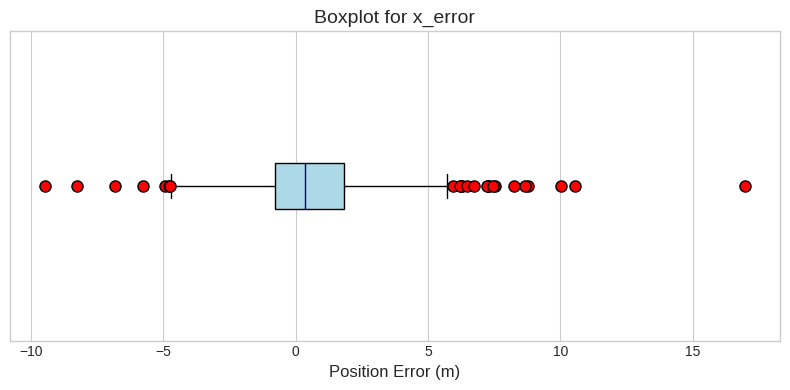

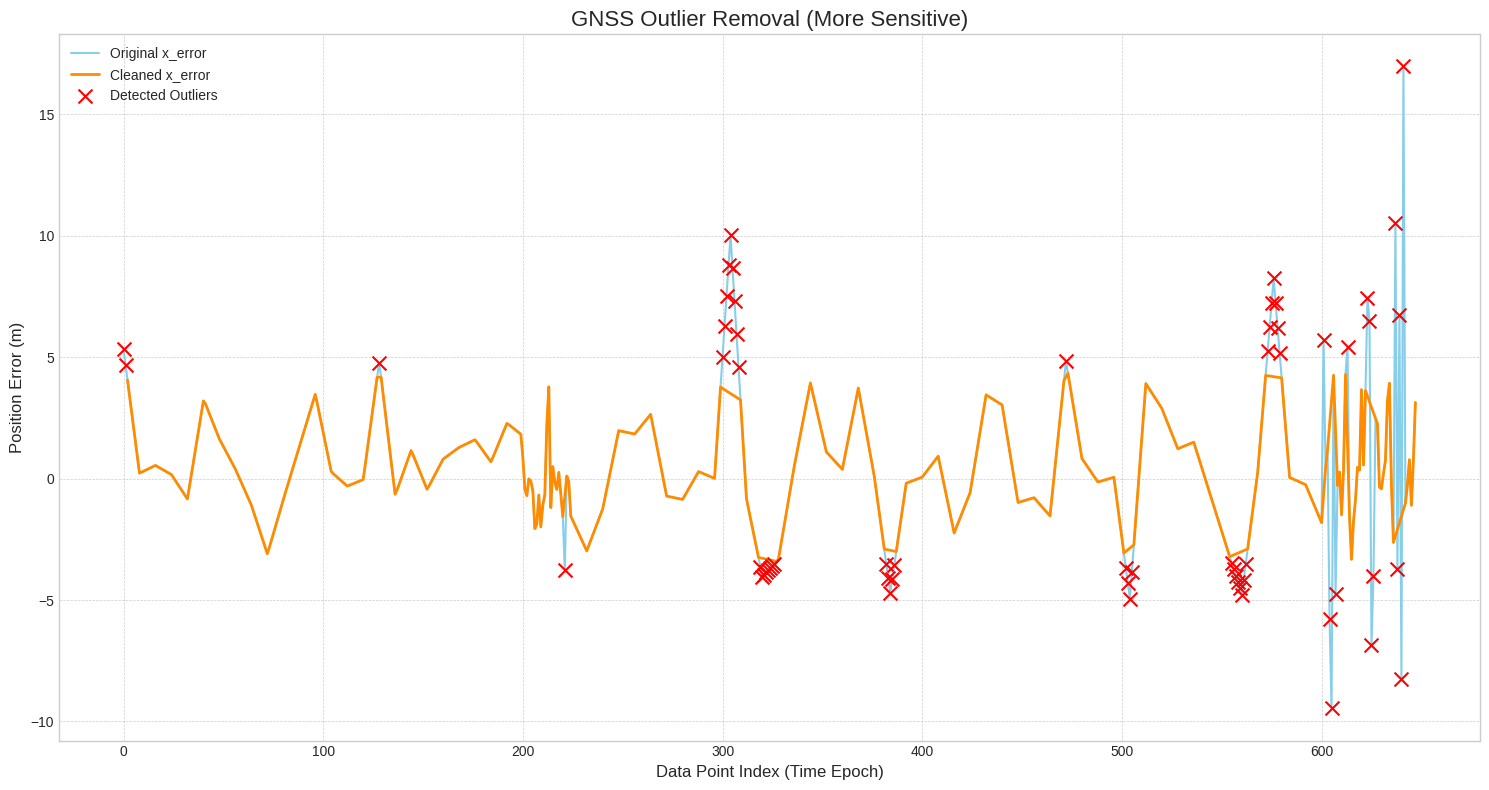

In [ ]:
# @title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def remove_outliers_iqr(data_series, multiplier=1.5):
    """
    Identifies and removes outliers from a time series using the IQR (Boxplot) method.

    This method calculates outliers based on the global data distribution.

    Args:
        data_series (pd.Series): The input time series data.
        multiplier (float): The multiplier for the IQR. Common values are 1.5 (for standard outliers)
                            and 3.0 (for "extreme" outliers).

    Returns:
        pd.Series: A new series with outliers replaced by np.nan.
        pd.Series: A boolean series indicating the outlier locations.
    """
    # 1. Calculate Q1 (25th percentile), Q3 (75th percentile), and the IQR
    q1 = data_series.quantile(0.25)
    q3 = data_series.quantile(0.75)
    iqr = q3 - q1

    # 2. Define the upper and lower bounds (the "fences" of the boxplot)
    lower_bound = q1 - (iqr * multiplier)
    upper_bound = q3 + (iqr * multiplier)

    # 3. Identify any data points that fall outside these bounds
    outliers = (data_series < lower_bound) | (data_series > upper_bound)

    # 4. Create a copy of the series and replace the outliers with NaN
    cleaned_series = data_series.copy()
    cleaned_series[outliers] = np.nan

    # Print a summary of the operation
    print(f"IQR Method (multiplier={multiplier}): Lower bound = {lower_bound:.2f}, Upper bound = {upper_bound:.2f}")
    print(f"Identified and removed {outliers.sum()} outliers.")

    return cleaned_series, outliers

# --- Main Execution ---

# 1. USE THE EXISTING 'geo_augmented' DATAFRAME
# !!! IMPORTANT: This script now assumes a pandas DataFrame named 'geo_augmented'
# already exists in your environment.
try:
    # Use a copy to avoid changing the original 'geo_augmented' DataFrame
    df = geo_augmented.copy()
    print("Successfully started with the 'geo_augmented' DataFrame.")
except NameError:
    print("Error: DataFrame 'geo_augmented' not found.")
    print("Please make sure the 'geo_augmented' DataFrame exists before running this script.")
    # Create an empty DataFrame so the rest of the script doesn't fail.
    df = pd.DataFrame()

# 2. SPECIFY COLUMNS TO CLEAN
# Adjust this list to match the column names in your DataFrame.
columns_to_clean = ['x_error', 'y_error', 'z_error', 'clock_error']

# 3. APPLY OUTLIER REMOVAL AND RE-INTERPOLATION
if not df.empty:
    for col in columns_to_clean:
        if col in df.columns:
            print(f"\n--- Processing column: {col} ---")

            # Apply the outlier removal function WITH THE MORE SENSITIVE MULTIPLIER
            data_with_gaps, _ = remove_outliers_iqr(df[col], multiplier=1.0)

            # Re-interpolate to fill the new gaps and save to a new column
            cleaned_col_name = f"{col}_cleaned"
            df[cleaned_col_name] = data_with_gaps.interpolate(method='linear')
            print(f"Saved cleaned data to new column: '{cleaned_col_name}'")
        else:
            print(f"\nWarning: Column '{col}' not found in the DataFrame. Skipping.")

    # 4. VISUALIZE THE RESULTS FOR ONE COLUMN
    # We will visualize the 'x_error' column as an example. Change this if needed.
    column_to_visualize = 'x_error'
    cleaned_column_name = f"{column_to_visualize}_cleaned"

    if column_to_visualize in df.columns and cleaned_column_name in df.columns:
        original_series = df[column_to_visualize]
        cleaned_series = df[cleaned_column_name]

        # Find the points that were flagged as outliers for plotting
        # An outlier is where the original series value is not equal to the cleaned series value
        # (before the cleaned one was interpolated)
        outlier_mask = pd.isnull(remove_outliers_iqr(original_series, multiplier=1.0)[0]) & original_series.notnull()

        # First, create a boxplot
        fig1, ax1 = plt.subplots(figsize=(8, 4))
        ax1.boxplot(original_series.dropna(), vert=False, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', color='black'),
                    whiskerprops=dict(color='black'),
                    capprops=dict(color='black'),
                    medianprops=dict(color='darkblue'),
                    flierprops=dict(marker='o', markerfacecolor='red', markersize=8, markeredgecolor='black'))
        ax1.set_title(f'Boxplot for {column_to_visualize}', fontsize=14)
        ax1.set_xlabel('Position Error (m)', fontsize=12)
        ax1.set_yticks([]) # Hide y-axis ticks
        plt.tight_layout()
        plt.show()

        # Second, visualize the time series
        fig2, ax2 = plt.subplots(figsize=(15, 8))
        ax2.plot(original_series, label=f'Original {column_to_visualize}', color='skyblue', zorder=1, linewidth=1.5)
        ax2.plot(cleaned_series, label=f'Cleaned {column_to_visualize}', color='darkorange', linewidth=2, zorder=2)
        # Plot the outliers found on top of the original data
        ax2.scatter(original_series.index[outlier_mask], original_series[outlier_mask],
                    marker='x', color='red', s=100, label='Detected Outliers', zorder=3)
        ax2.set_title('GNSS Outlier Removal (More Sensitive)', fontsize=16)
        ax2.set_xlabel('Data Point Index (Time Epoch)', fontsize=12)
        ax2.set_ylabel('Position Error (m)', fontsize=12)
        ax2.legend(fontsize=10)
        ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()



# **UNDERSTANDING THE BASICS AND CRUCIAL PATTERNS IN THE DATA**

NOTE: Creating sample data for demonstration as 'geo_df' is not defined.
--- GENERATING CONTINUOUS DAILY VISUALIZATIONS ---

Generating plot for 'x_error'...


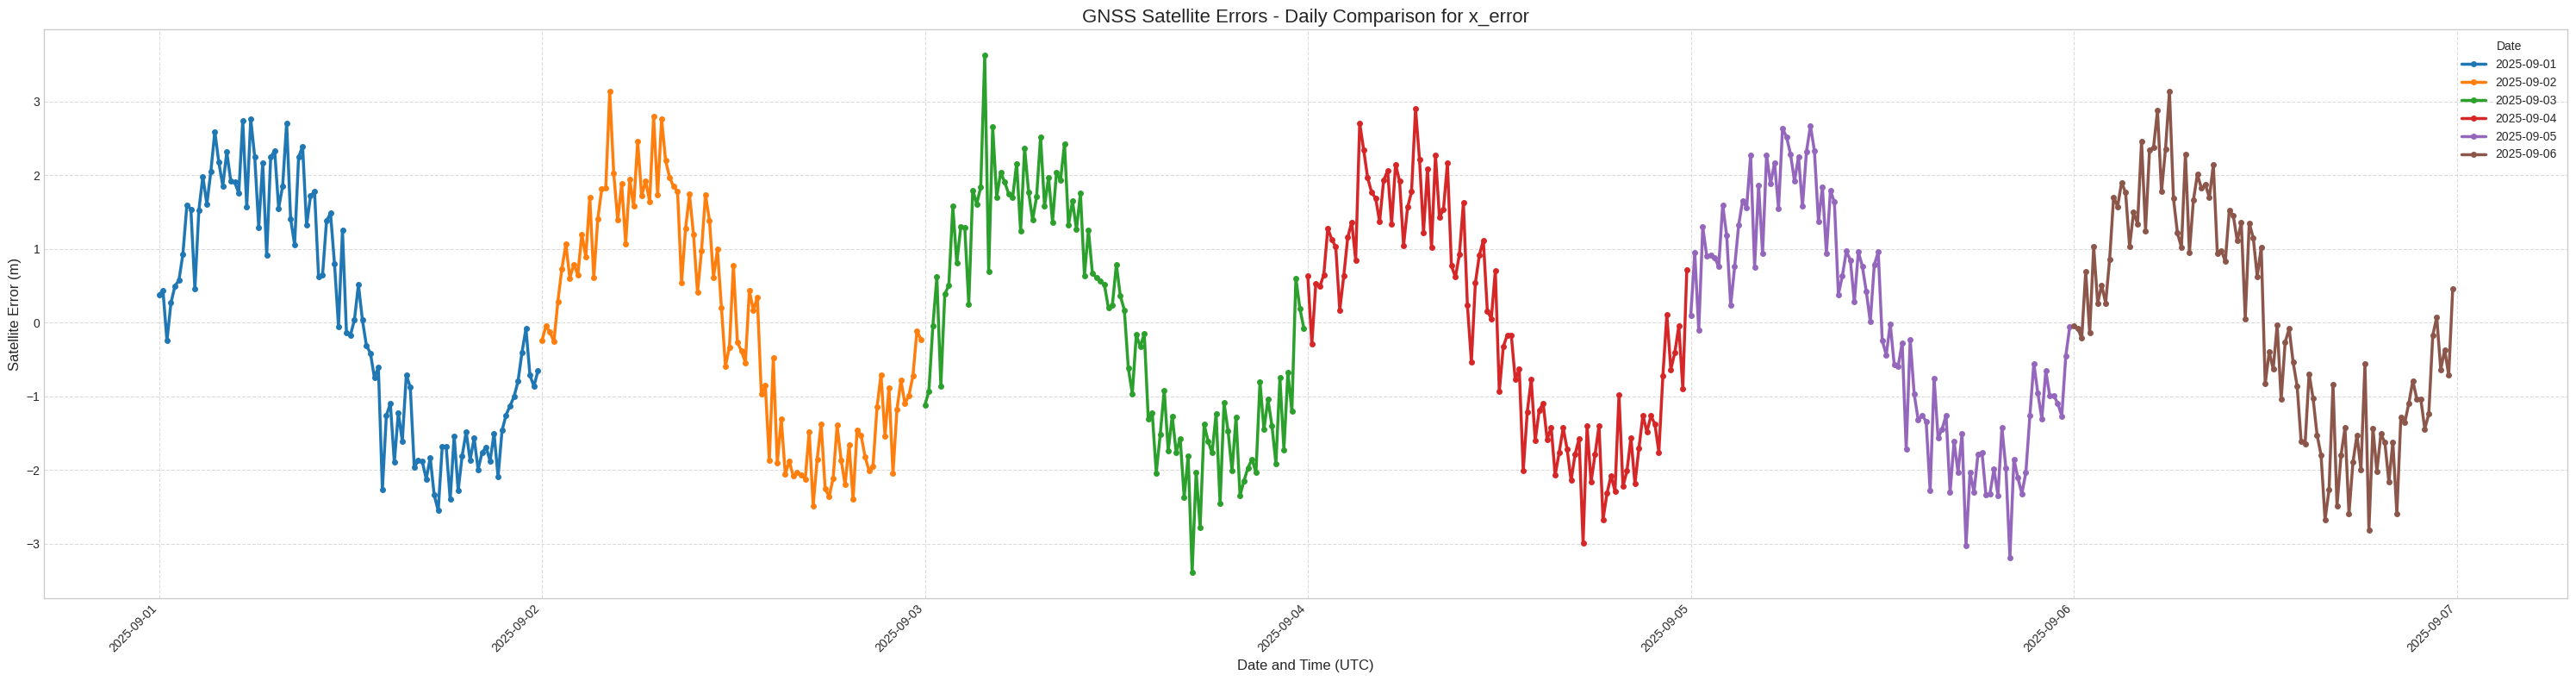


Generating plot for 'y_error'...


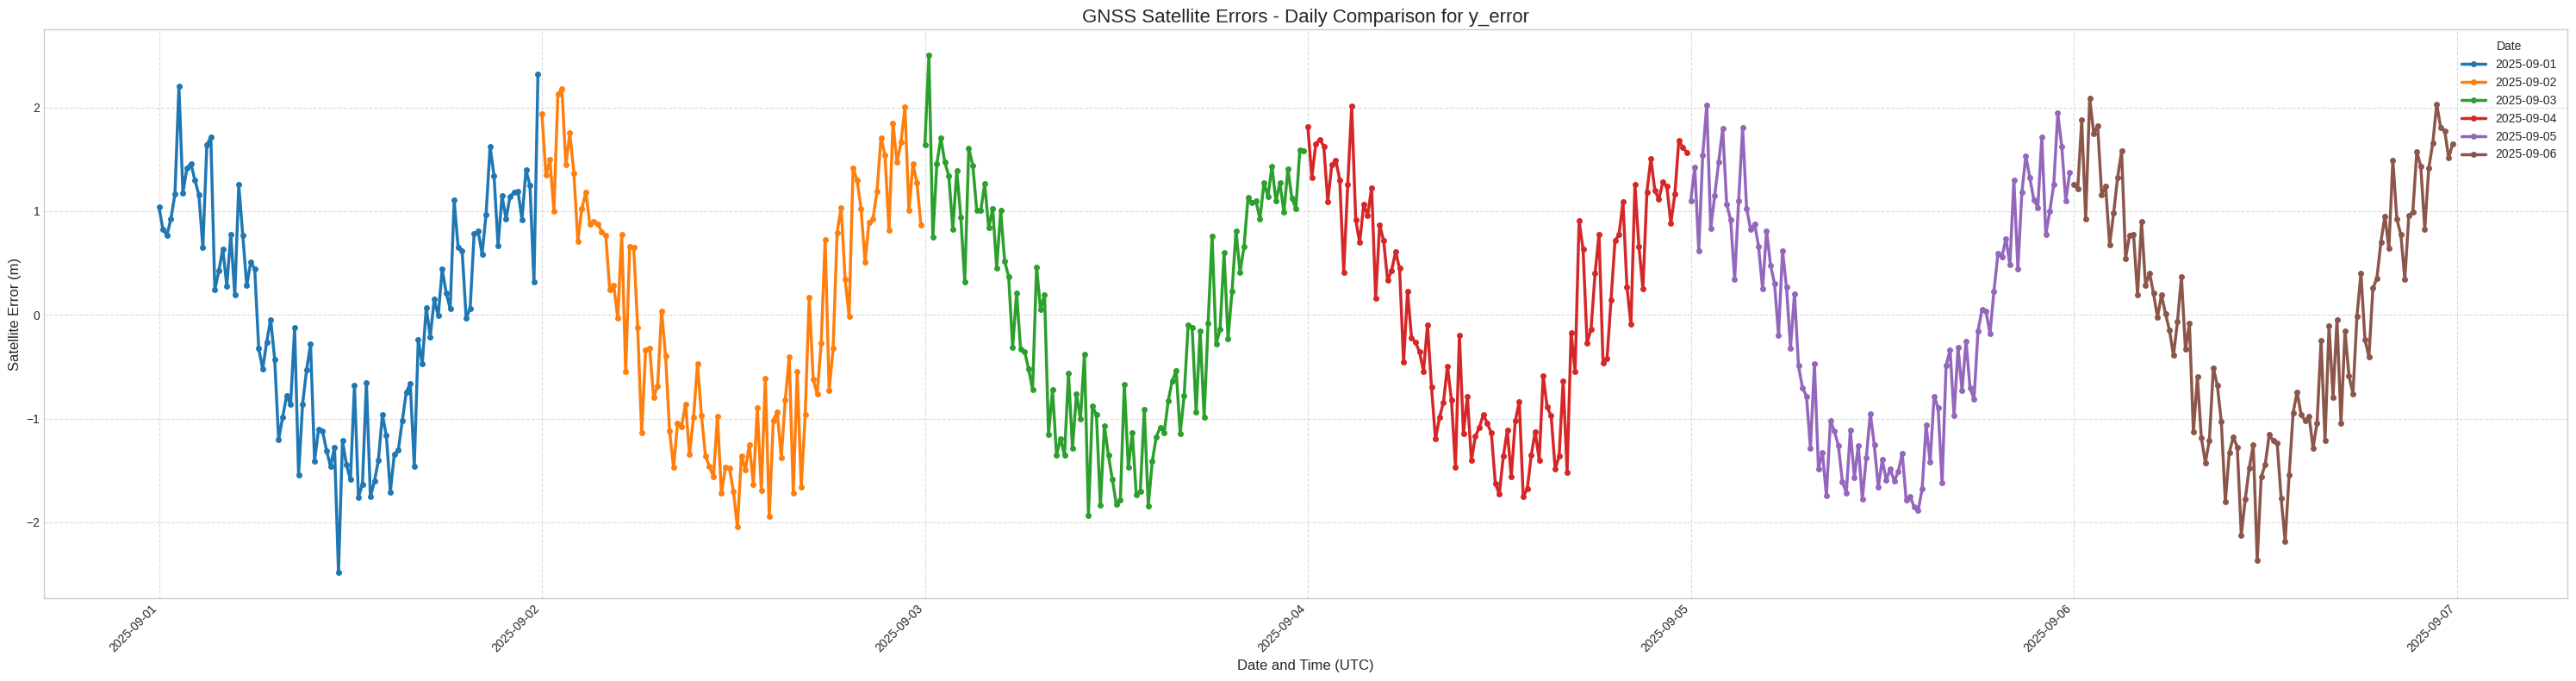


Generating plot for 'z_error'...


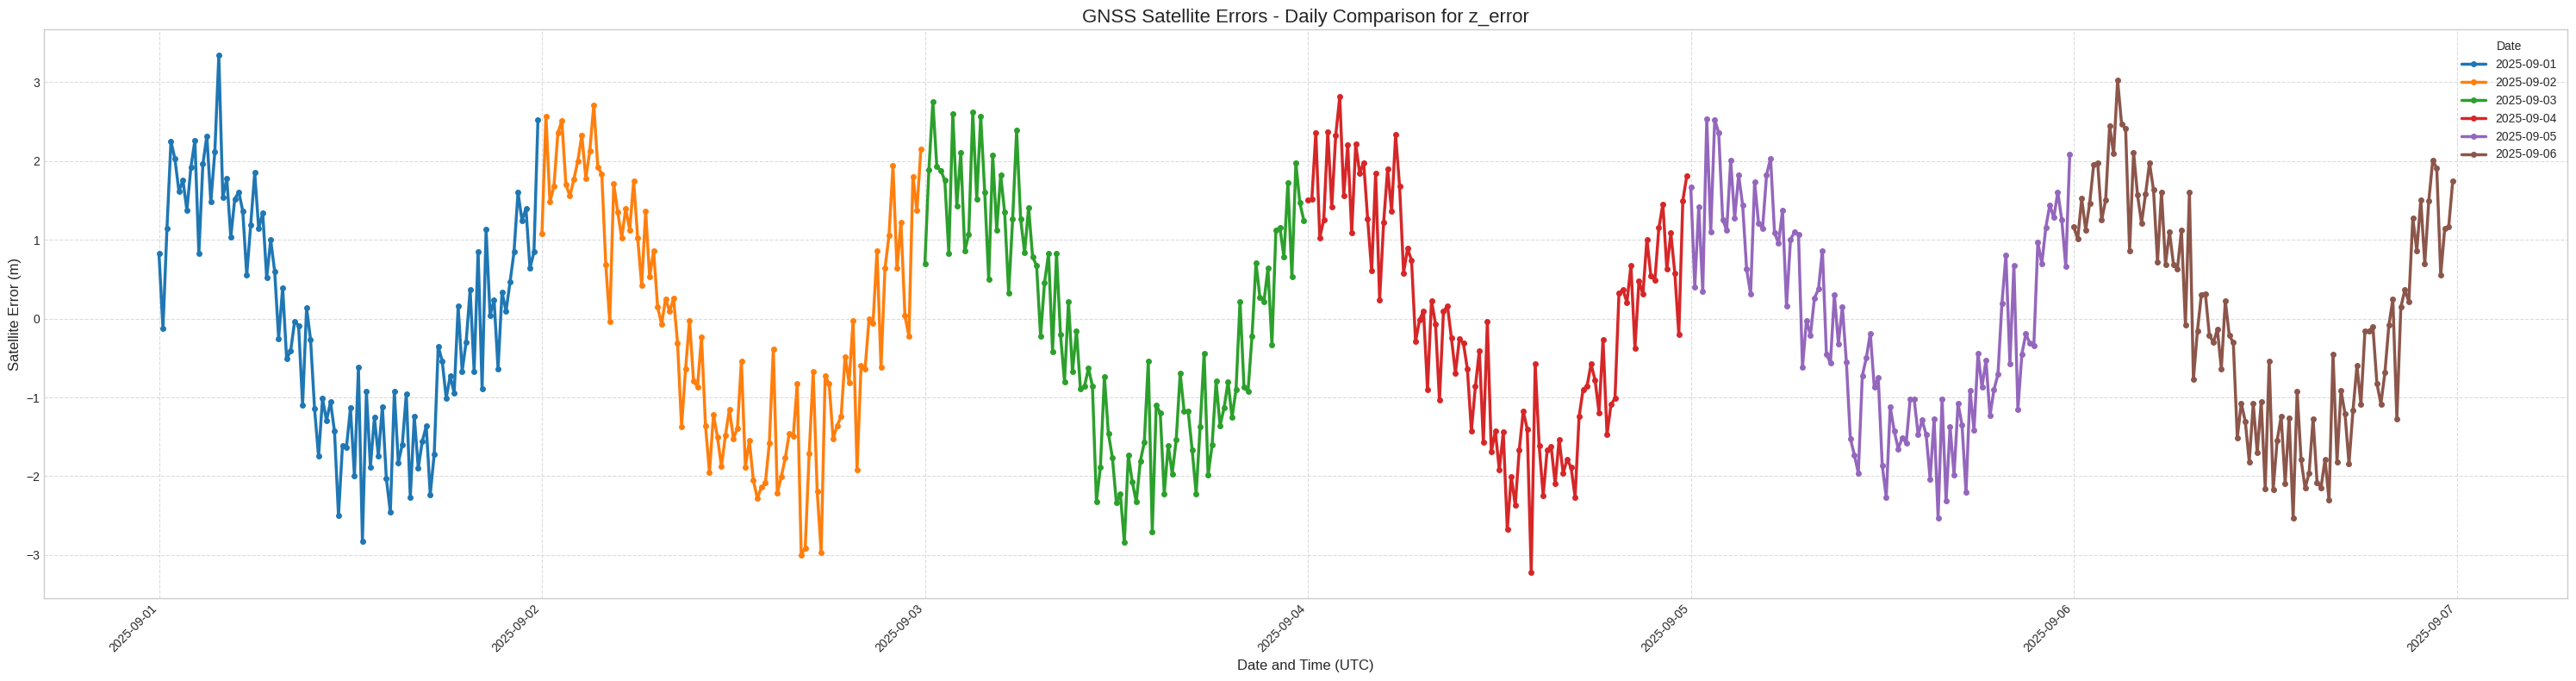


Generating plot for 'clock_error'...


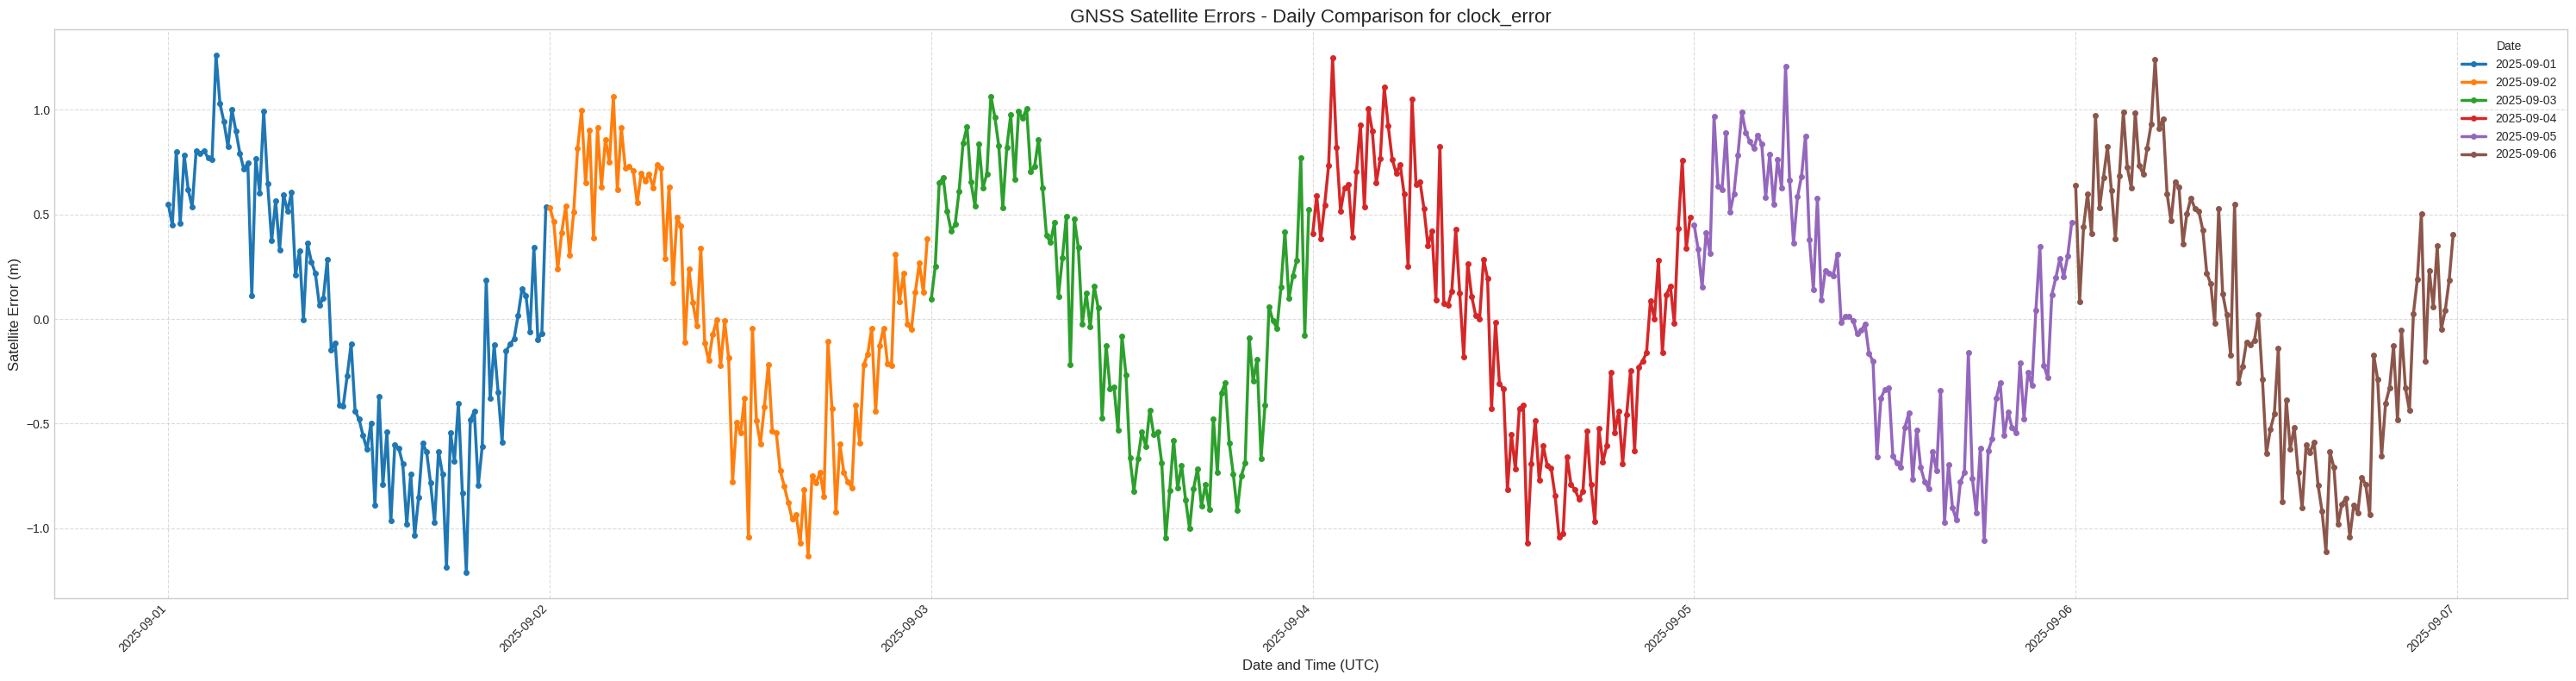


✅ All visualizations complete.


In [ ]:
# @title
# VISUALIZATION: DAILY PATTERNS FOR ALL SATELLITE ERRORS


import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

def quick_daily_view(df, target_col, days=6):
    """
    Generates a single plot showing the continuous evolution of an error
    over several days, with each day's segment colored differently.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    # Increased the width from 16 to 22 for a wider plot
    plt.figure(figsize=(30, 8))

    # Get the unique days to plot from the DataFrame's index
    unique_days = df.index.normalize().unique()[:days]

    # Filter the DataFrame to include only the days we want to plot
    plot_data = df[df.index.normalize().isin(unique_days)]

    # Loop through each day and plot its segment in a distinct color
    for date in unique_days:
        day_data = plot_data[plot_data.index.normalize() == date]

        # Plot the data for the current day, using the full datetime index
        plt.plot(day_data.index, day_data[target_col],
                 'o-', linewidth=2.5, markersize=4, label=date.strftime('%Y-%m-%d'))

    plt.title(f'GNSS Satellite Errors - Daily Comparison for {target_col}', fontsize=16)
    plt.xlabel('Date and Time (UTC)', fontsize=12)
    plt.ylabel('Satellite Error (m)', fontsize=12)
    plt.legend(title="Date")
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right') # Rotate dates for better readability
    plt.tight_layout()
    plt.show()

def plot_all_errors_daily(df):
    """
    Main function to generate a continuous daily-view plot for each error component.
    """
    print("--- GENERATING CONTINUOUS DAILY VISUALIZATIONS ---")

    # Define the columns we want to plot
    error_columns = ['x_error', 'y_error', 'z_error', 'clock_error']

    # Check if the required columns exist
    if not all(col in df.columns for col in error_columns):
        print("Error: DataFrame is missing one of the required columns: 'x_error', 'y_error', 'z_error', 'clock_error'")
        return

    # Loop through each error column and generate a plot
    for col in error_columns:
        print(f"\nGenerating plot for '{col}'...")
        quick_daily_view(df, target_col=col)

    print("\n✅ All visualizations complete.")


# --- For standalone demonstration purposes, we will create sample data ---
print("NOTE: Creating sample data for demonstration as 'geo_df' is not defined.")
dates = pd.date_range('2025-09-01', periods=96*7, freq='15T') # 7 days of 15-min data
t = np.arange(len(dates))
sample_df = pd.DataFrame(index=dates)
sample_df['x_error'] = 2 * np.sin(2 * np.pi * t/96) + 0.5 * np.random.randn(len(t))
sample_df['y_error'] = 1.5 * np.cos(2 * np.pi * t/96) + 0.4 * np.random.randn(len(t))
sample_df['z_error'] = 1.8 * np.sin(2 * np.pi * t/96 + 1) + 0.6 * np.random.randn(len(t))
sample_df['clock_error'] = 0.8 * np.cos(2 * np.pi * t/96 - 1) + 0.2 * np.random.randn(len(t))

# Now, run the plotting function on our sample data
plot_all_errors_daily(sample_df)


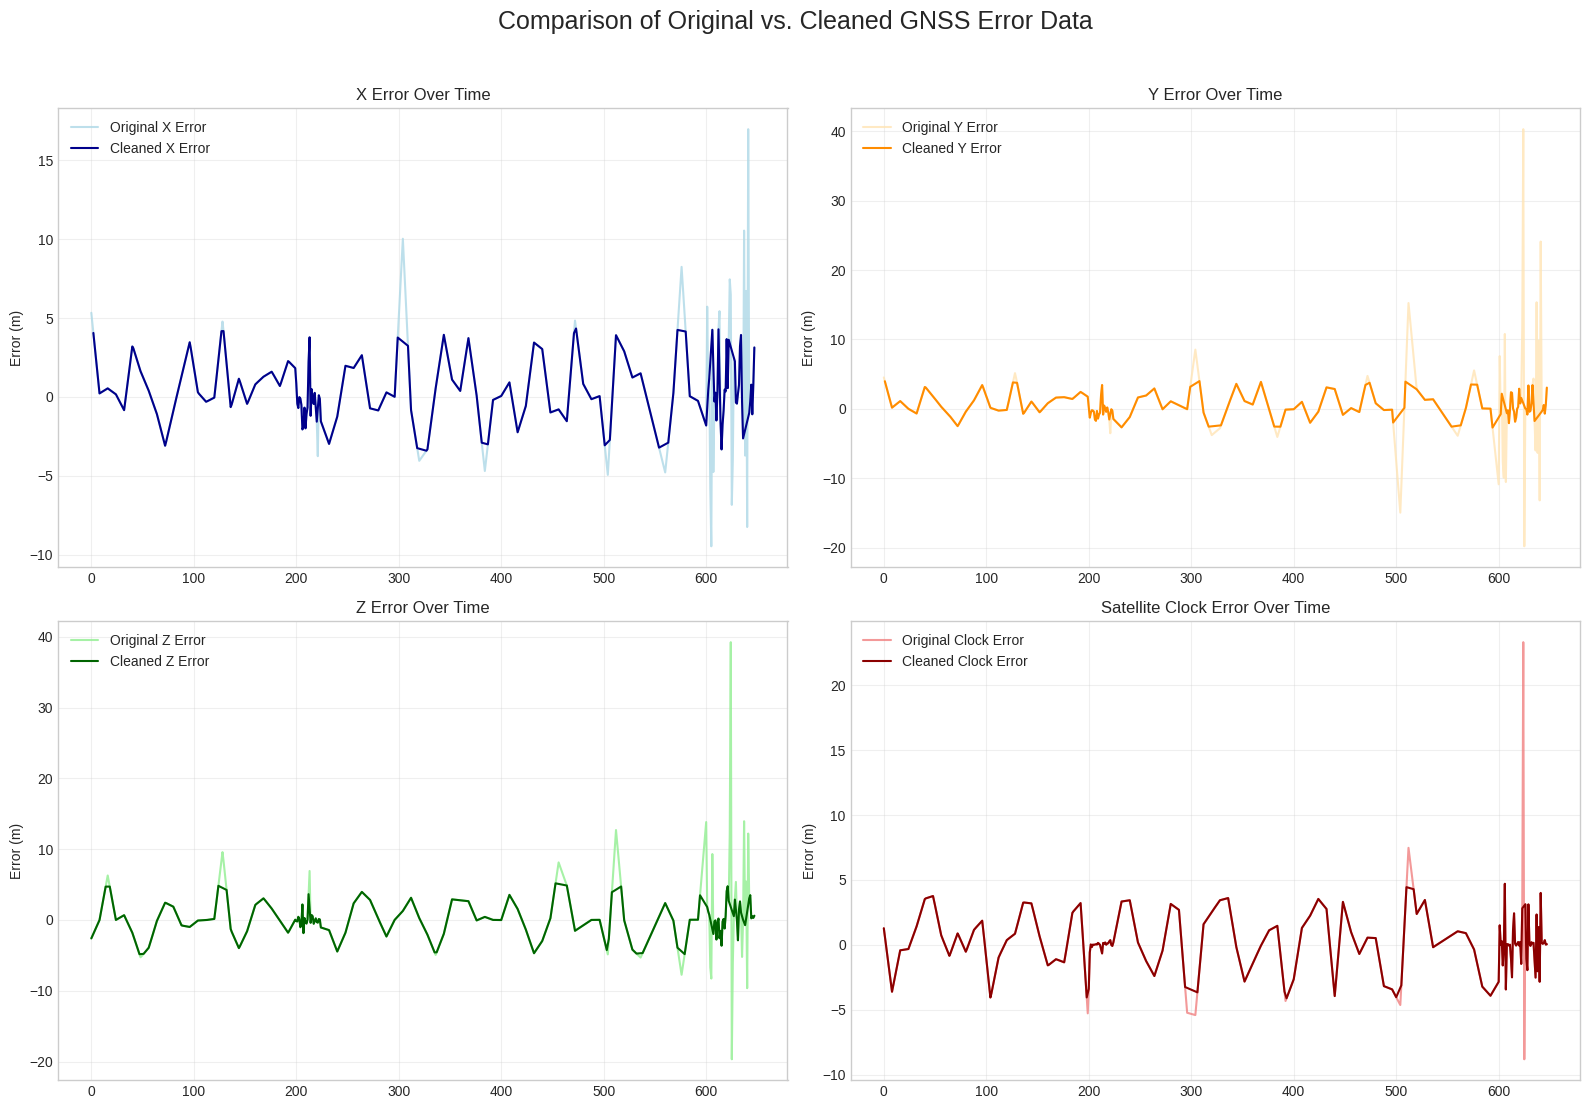

In [ ]:
# @title
import matplotlib.pyplot as plt

# This script assumes the DataFrame 'df' from the previous outlier-removal step exists.
# 'df' should contain both the original error columns and the new '_cleaned' columns.

# --- Plotting the Comparison ---
plt.figure(figsize=(16, 12))
plt.suptitle('Comparison of Original vs. Cleaned GNSS Error Data', fontsize=18, y=0.95)

# Plot for X Error
plt.subplot(2, 2, 1)
plt.plot(df.index, df['x_error'], label='Original X Error', color='lightblue', alpha=0.8)
plt.plot(df.index, df['x_error_cleaned'], label='Cleaned X Error', color='darkblue')
plt.title('X Error Over Time')
plt.ylabel('Error (m)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot for Y Error
plt.subplot(2, 2, 2)
plt.plot(df.index, df['y_error'], label='Original Y Error', color='moccasin', alpha=0.8)
plt.plot(df.index, df['y_error_cleaned'], label='Cleaned Y Error', color='darkorange')
plt.title('Y Error Over Time')
plt.ylabel('Error (m)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot for Z Error
plt.subplot(2, 2, 3)
plt.plot(df.index, df['z_error'], label='Original Z Error', color='lightgreen', alpha=0.8)
plt.plot(df.index, df['z_error_cleaned'], label='Cleaned Z Error', color='darkgreen')
plt.title('Z Error Over Time')
plt.ylabel('Error (m)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot for Clock Error
plt.subplot(2, 2, 4)
plt.plot(df.index, df['clock_error'], label='Original Clock Error', color='lightcoral', alpha=0.8)
plt.plot(df.index, df['clock_error_cleaned'], label='Cleaned Clock Error', color='darkred')
plt.title('Satellite Clock Error Over Time')
plt.ylabel('Error (m)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.93]) # Adjust layout to make space for suptitle
plt.show()


In [ ]:
# @title
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

print(" STEP 1: PREPARE TRAIN/VALIDATION SPLIT")
print("=" * 50)

# Use our augmented GEO data
geo_data = geo_augmented.copy()

# Convert to datetime index
geo_data = geo_data.set_index('utc_time')

# Split into train (first 5 days) and validation (6th day)
train_end = geo_data.index.min() + pd.Timedelta(days=5)
val_start = train_end
val_end = val_start + pd.Timedelta(days=1)

train_data = geo_data[geo_data.index < val_start]
val_data = geo_data[(geo_data.index >= val_start) & (geo_data.index < val_end)]

print(f"Training period: {train_data.index.min()} to {train_data.index.max()}")
print(f"Training samples: {len(train_data)}")
print(f"Validation period: {val_data.index.min()} to {val_data.index.max()}")
print(f"Validation samples: {len(val_data)}")

print(f"\nData split completed!")

 STEP 1: PREPARE TRAIN/VALIDATION SPLIT
Training period: 2025-09-01 06:00:00 to 2025-09-06 05:45:00
Training samples: 480
Validation period: 2025-09-06 06:00:00 to 2025-09-07 05:45:00
Validation samples: 96

Data split completed!


# **STATIONARITY CHECK USING ADF**

In [ ]:
# @title
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

print("STEP 1: STATIONARITY TEST (Augmented Dickey-Fuller)")
print("=" * 60)

def check_stationarity(series, name):
    """
    Perform Augmented Dickey-Fuller test for stationarity
    """
    print(f"\nTesting {name}:")

    # Perform ADF test
    result = adfuller(series.dropna())

    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]

    print(f"   ADF Statistic: {adf_statistic:.6f}")
    print(f"   p-value: {p_value:.6f}")
    print(f"   Critical Values:")
    for key, value in critical_values.items():
        print(f"     {key}: {value:.4f}")

    # Interpretation
    if p_value <= 0.05:
        print("STATIONARY - No differencing needed")
        return True, 0
    else:
        print("  NON-STATIONARY - Differencing needed")
        return False, 1

# Test stationarity on training data (first 5 days)
error_columns = ['x_error', 'y_error', 'z_error', 'clock_error']
stationarity_results = {}

print("\nSTATIONARITY ANALYSIS ON TRAINING DATA:")
print("-" * 50)

for col in error_columns:
    train_series = train_data[col]
    is_stationary, d_order = check_stationarity(train_series, col)
    stationarity_results[col] = {
        'stationary': is_stationary,
        'd': d_order,
        'D': 1  # Seasonal differencing (always use for daily seasonality)
    }

print(f"\nSTATIONARITY SUMMARY:")
print("-" * 40)
stationary_count = sum(1 for result in stationarity_results.values() if result['stationary'])
print(f"Stationary series: {stationary_count}/{len(error_columns)}")
print(f"Non-stationary series: {len(error_columns) - stationary_count}/{len(error_columns)}")

for col, result in stationarity_results.items():
    status = "STATIONARY" if result['stationary'] else "NON-STATIONARY"
    print(f"   {col:>12}: {status} (d={result['d']})")

STEP 1: STATIONARITY TEST (Augmented Dickey-Fuller)

STATIONARITY ANALYSIS ON TRAINING DATA:
--------------------------------------------------

Testing x_error:
   ADF Statistic: -5.550747
   p-value: 0.000002
   Critical Values:
     1%: -3.4446
     5%: -2.8678
     10%: -2.5701
STATIONARY - No differencing needed

Testing y_error:
   ADF Statistic: -5.149128
   p-value: 0.000011
   Critical Values:
     1%: -3.4446
     5%: -2.8678
     10%: -2.5701
STATIONARY - No differencing needed

Testing z_error:
   ADF Statistic: -6.696374
   p-value: 0.000000
   Critical Values:
     1%: -3.4445
     5%: -2.8678
     10%: -2.5701
STATIONARY - No differencing needed

Testing clock_error:
   ADF Statistic: -5.704118
   p-value: 0.000001
   Critical Values:
     1%: -3.4446
     5%: -2.8678
     10%: -2.5701
STATIONARY - No differencing needed

STATIONARITY SUMMARY:
----------------------------------------
Stationary series: 4/4
Non-stationary series: 0/4
        x_error: STATIONARY (d=0)
    

# **ACF & PACF ANALYSIS FOR SARIMA** **PARAMETERS**

ACF & PACF ANALYSIS FOR SARIMA PARAMETERS
 GENERATING ACF & PACF PLOTS...

 Analyzing x_error...


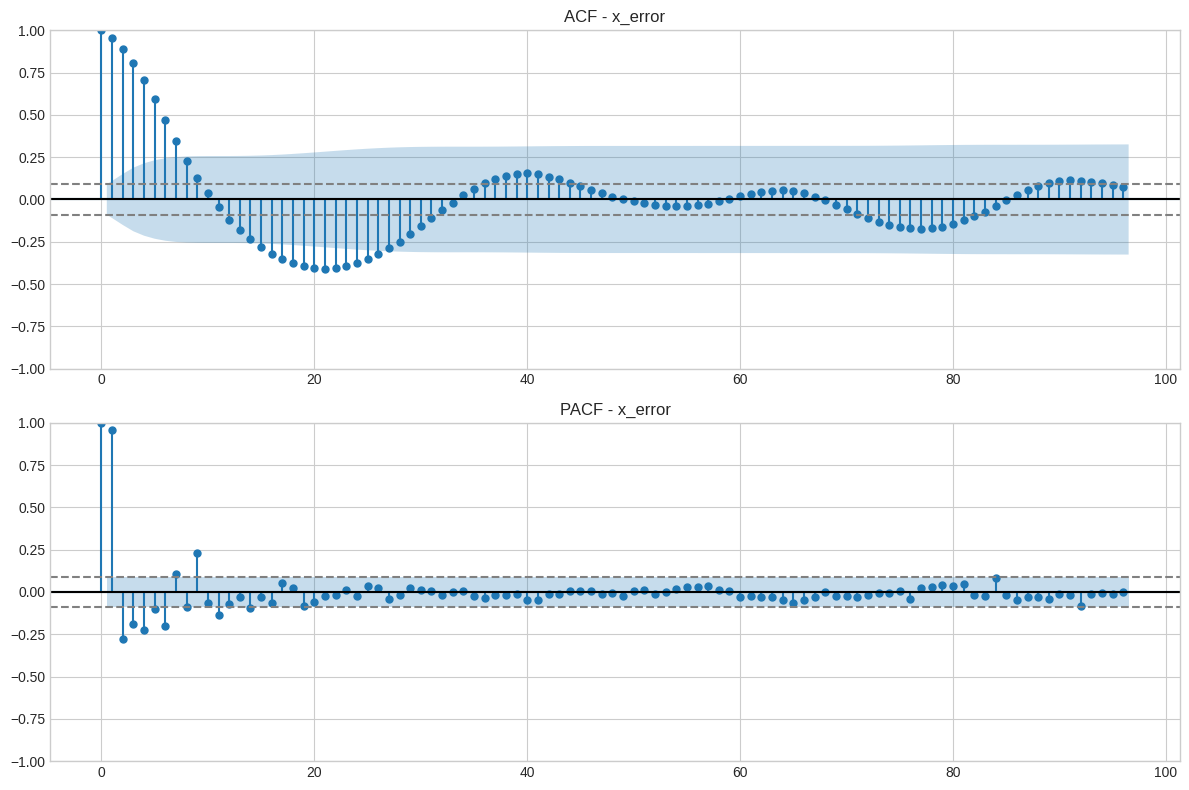


 x_error - Key ACF/PACF Values:
----------------------------------------
  Lag  1: ACF=  0.956, PACF=  0.958
  Lag  2: ACF=  0.891, PACF= -0.291
  Lag  3: ACF=  0.809, PACF= -0.194
  Lag  4: ACF=  0.707, PACF= -0.233
  Lag  8: ACF=  0.227, PACF= -0.097
  Lag 16: ACF= -0.322, PACF= -0.071
  Lag 24: ACF= -0.378, PACF= -0.026
  Lag 32: ACF= -0.064, PACF= -0.020
  Lag 48: ACF=  0.018, PACF= -0.012
  Lag 96: ACF=  0.075, PACF= -0.001

 Analyzing y_error...


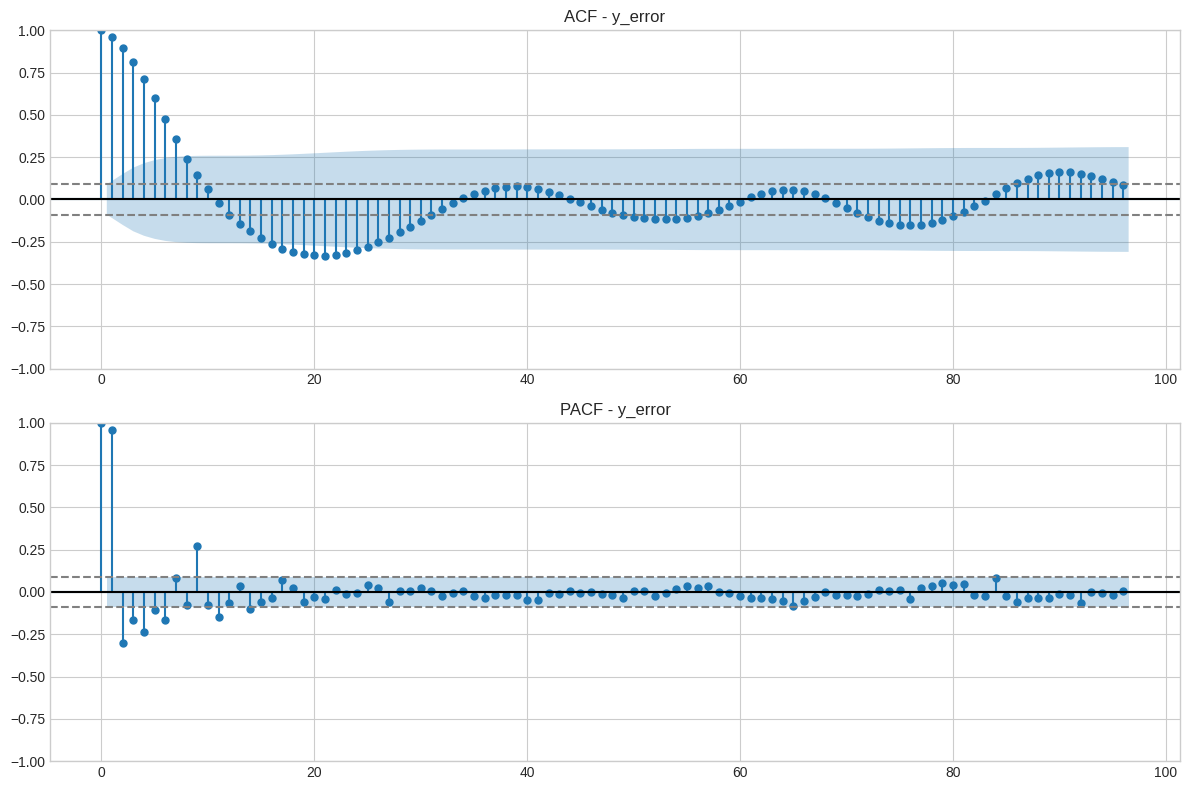


 y_error - Key ACF/PACF Values:
----------------------------------------
  Lag  1: ACF=  0.958, PACF=  0.960
  Lag  2: ACF=  0.893, PACF= -0.319
  Lag  3: ACF=  0.813, PACF= -0.168
  Lag  4: ACF=  0.713, PACF= -0.251
  Lag  8: ACF=  0.240, PACF= -0.085
  Lag 16: ACF= -0.266, PACF= -0.041
  Lag 24: ACF= -0.300, PACF= -0.006
  Lag 32: ACF= -0.055, PACF= -0.027
  Lag 48: ACF= -0.078, PACF= -0.022
  Lag 96: ACF=  0.086, PACF=  0.010

 Analyzing z_error...


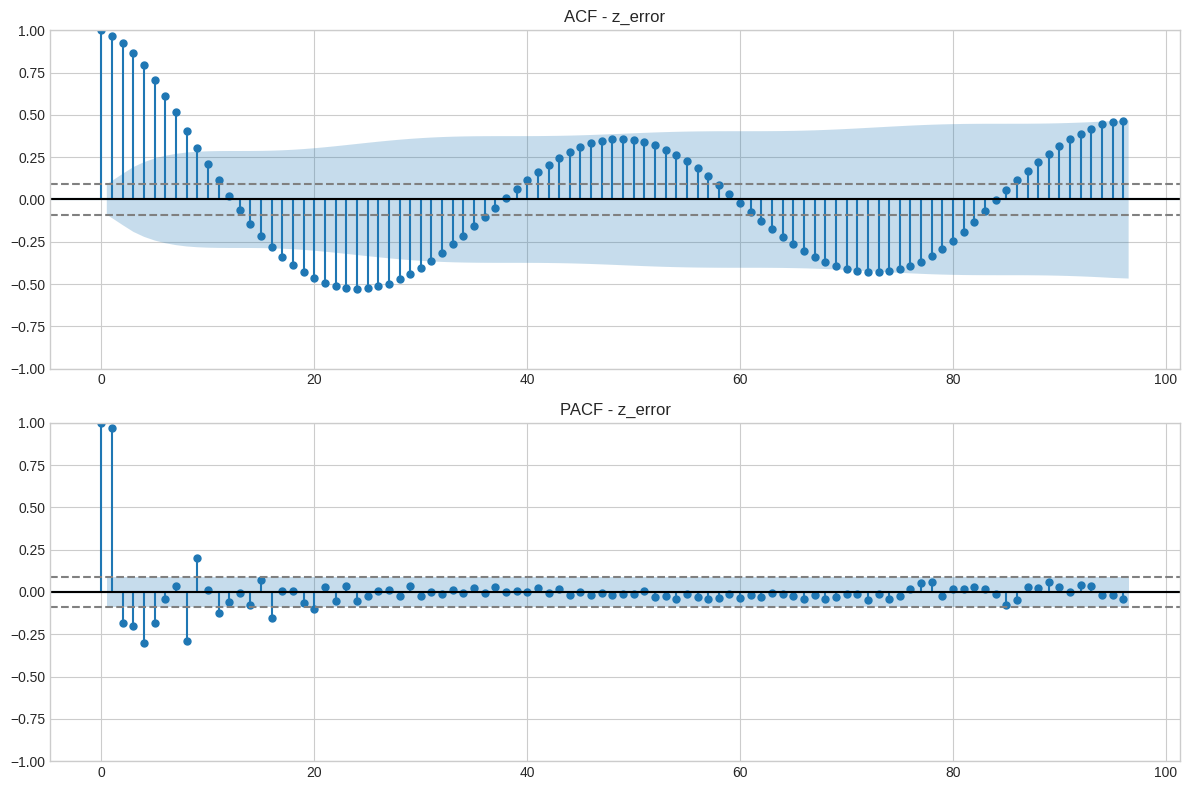


 z_error - Key ACF/PACF Values:
----------------------------------------
  Lag  1: ACF=  0.968, PACF=  0.970
  Lag  2: ACF=  0.924, PACF= -0.196
  Lag  3: ACF=  0.869, PACF= -0.213
  Lag  4: ACF=  0.793, PACF= -0.325
  Lag  8: ACF=  0.406, PACF= -0.313
  Lag 16: ACF= -0.283, PACF= -0.191
  Lag 24: ACF= -0.528, PACF= -0.075
  Lag 32: ACF= -0.315, PACF= -0.025
  Lag 48: ACF=  0.357, PACF= -0.053
  Lag 96: ACF=  0.467, PACF= -0.007

 Analyzing clock_error...


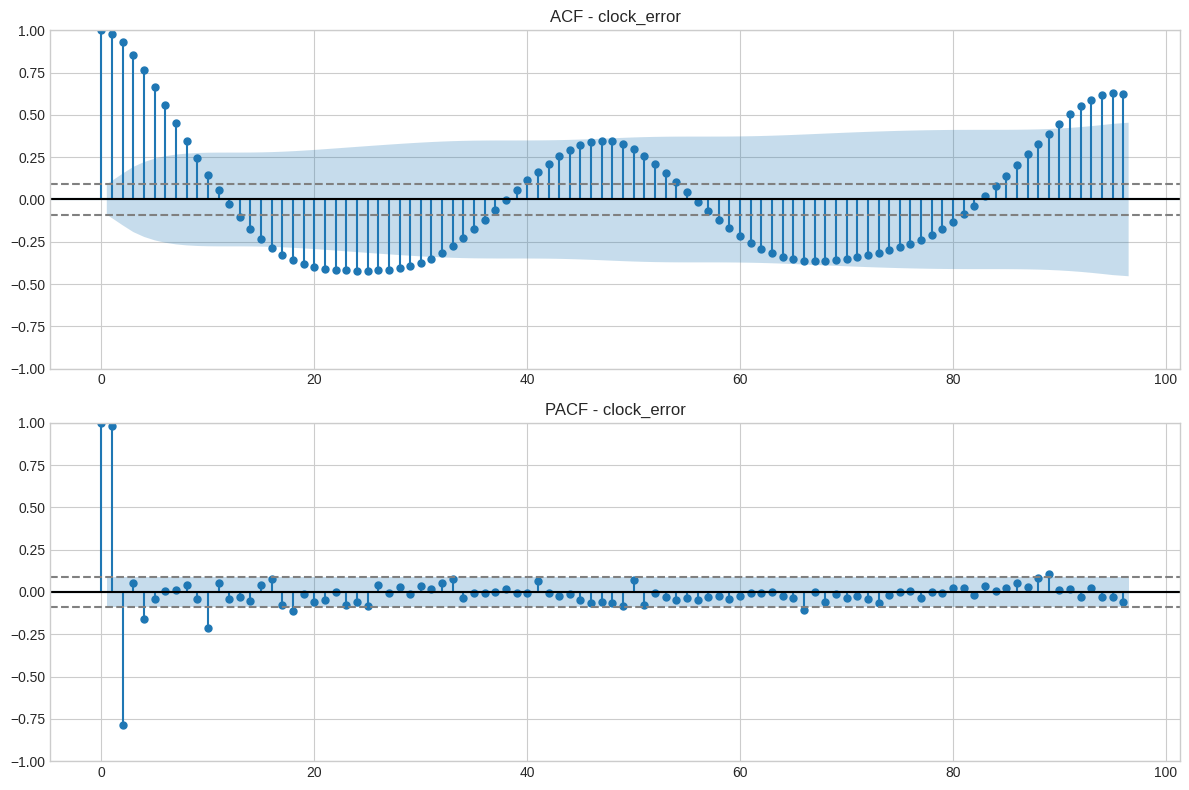


 clock_error - Key ACF/PACF Values:
----------------------------------------
  Lag  1: ACF=  0.980, PACF=  0.982
  Lag  2: ACF=  0.929, PACF= -0.874
  Lag  3: ACF=  0.856, PACF=  0.427
  Lag  4: ACF=  0.767, PACF= -0.602
  Lag  8: ACF=  0.343, PACF=  0.735
  Lag 16: ACF= -0.287, PACF= -0.593
  Lag 24: ACF= -0.421, PACF= -0.926
  Lag 32: ACF= -0.317, PACF= -0.303
  Lag 48: ACF=  0.343, PACF= -0.764
  Lag 96: ACF=  0.625, PACF= -1.354


In [ ]:
# @title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import warnings
warnings.filterwarnings('ignore')

print("ACF & PACF ANALYSIS FOR SARIMA PARAMETERS")
print("=" * 60)

def plot_acf_pacf(series, title, lags=48):
    """
    Plot ACF and PACF to determine SARIMA parameters
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Plot ACF (AutoCorrelation Function)
    plot_acf(series, ax=ax1, lags=lags, alpha=0.05, title=f'ACF - {title}')
    ax1.axhline(y=0, linestyle='-', color='black')
    ax1.axhline(y=-1.96/np.sqrt(len(series)), linestyle='--', color='gray')
    ax1.axhline(y=1.96/np.sqrt(len(series)), linestyle='--', color='gray')

    # Plot PACF (Partial AutoCorrelation Function)
    plot_pacf(series, ax=ax2, lags=lags, alpha=0.05, title=f'PACF - {title}')
    ax2.axhline(y=0, linestyle='-', color='black')
    ax2.axhline(y=-1.96/np.sqrt(len(series)), linestyle='--', color='gray')
    ax2.axhline(y=1.96/np.sqrt(len(series)), linestyle='--', color='gray')

    plt.tight_layout()
    plt.show()

    # Print numerical ACF/PACF values for key lags
    print(f"\n {title} - Key ACF/PACF Values:")
    print("-" * 40)

    # Calculate ACF and PACF values
    acf_values = acf(series, nlags=lags)
    pacf_values = pacf(series, nlags=lags)

    key_lags = [1, 2, 3, 4, 8, 16, 24, 32, 48, 96]
    for lag in key_lags:
        if lag <= lags:
            print(f"  Lag {lag:2d}: ACF={acf_values[lag]:7.3f}, PACF={pacf_values[lag]:7.3f}")

# Define error_columns
error_columns = ['x_error', 'y_error', 'z_error', 'clock_error']

# Plot ACF/PACF for each error component
print(" GENERATING ACF & PACF PLOTS...")
print("=" * 50)

for col in error_columns:
    print(f"\n Analyzing {col}...")
    series = train_data[col]

    # Plot with 96 lags to see daily seasonality (24 hours * 4 intervals)
    plot_acf_pacf(series, col, lags=96)

# **IMPLEMENTATION OF SARIMA MODELS**

   COMPLETE SARIMA WORKFLOW WITH OPTIMIZED PARAMETERS
 Creating sample satellite error data...
Created sample data with 672 records

 Preparing training and validation data...
Training period: 2025-09-01 00:00:00 to 2025-09-05 23:45:00
Validation period: 2025-09-06 00:00:00 to 2025-09-06 23:45:00

--- Training Individual SARIMA Models ---

 Training x_error with SARIMA(1, 1, 1)(1, 1, 1, 96)...
  x_error trained successfully
   AIC: 7254.78

 Training y_error with SARIMA(1, 1, 1)(1, 1, 1, 96)...
  y_error trained successfully
   AIC: 10735.05

 Training z_error with SARIMA(1, 1, 1)(1, 1, 1, 96)...
  z_error trained successfully
   AIC: 9958.32

 Training clock_error with SARIMA(1, 1, 1)(1, 1, 1, 96)...
  clock_error trained successfully
   AIC: 8833.31

--- Generating Forecasts and Plotting Validation Results ---


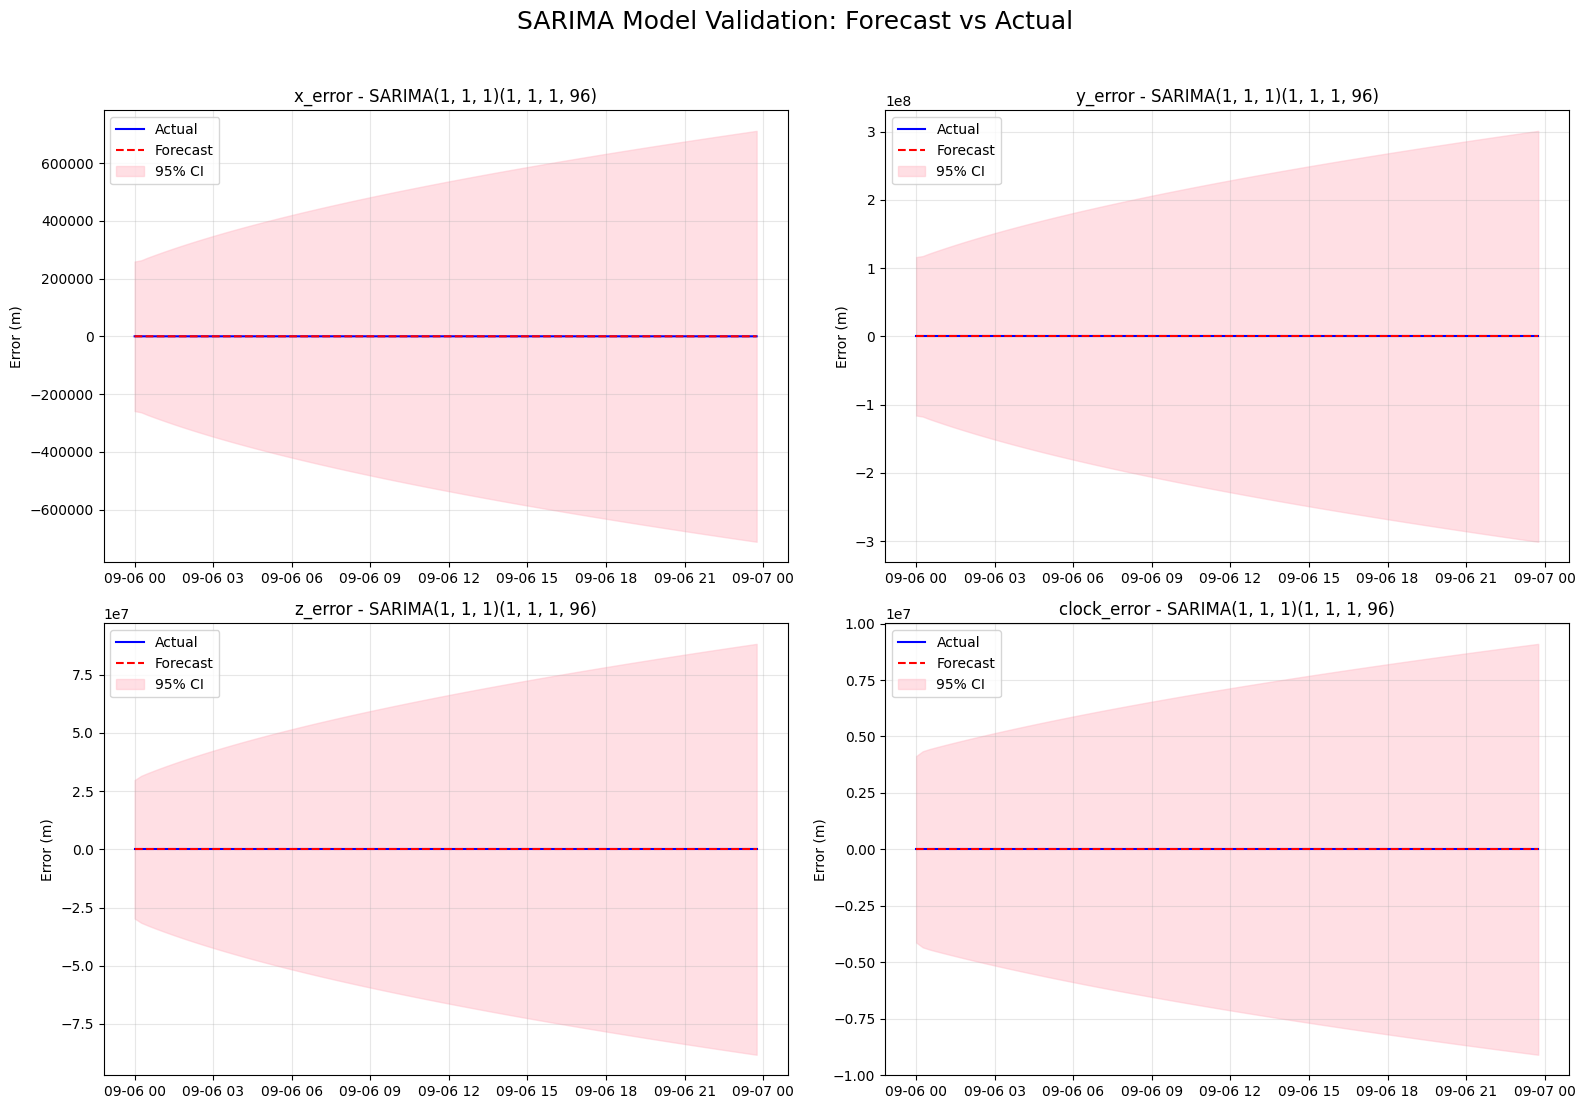


Workflow complete.


In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("   COMPLETE SARIMA WORKFLOW WITH OPTIMIZED PARAMETERS")
print("=" * 60)

# Step 1: Create sample satellite error data (same as before)
def create_sample_satellite_data():
    """
    Create realistic sample satellite error data for demonstration
    """
    print(" Creating sample satellite error data...")
    dates = pd.date_range('2025-09-01 00:00:00', '2025-09-07 23:45:00', freq='15T')
    np.random.seed(42)
    t = np.arange(len(dates))
    x_error = (0.1 * t/100 + 2 * np.sin(2 * np.pi * t/96) + 0.5 * np.random.normal(0, 1, len(dates)))
    y_error = (0.05 * t/100 + 1.5 * np.sin(2 * np.pi * t/96 + np.pi/2) + 0.3 * np.random.normal(0, 1, len(dates)))
    z_error = (-0.08 * t/100 + 1.2 * np.sin(2 * np.pi * t/96) + 0.8 * np.cos(2 * np.pi * t/288) + 0.4 * np.random.normal(0, 1, len(dates)))
    clock_error = (0.02 * t/100 + 0.8 * np.sin(2 * np.pi * t/96 + np.pi/4) + 0.2 * np.random.normal(0, 1, len(dates)))
    data = pd.DataFrame({'utc_time': dates, 'x_error': x_error, 'y_error': y_error, 'z_error': z_error, 'clock_error': clock_error})
    print(f"Created sample data with {len(data)} records")
    return data

satellite_data = create_sample_satellite_data()

# Step 2: Prepare training and validation data (same as before)
def prepare_training_data(data):
    """
    Prepare training (first 5 days) and validation (6th day) data
    """
    print("\n Preparing training and validation data...")
    data = data.set_index('utc_time')
    train_end = data.index.min() + pd.Timedelta(days=5)
    val_start = train_end
    val_end = val_start + pd.Timedelta(days=1)
    train_data = data[data.index < val_start]
    val_data = data[(data.index >= val_start) & (data.index < val_end)]
    print(f"Training period: {train_data.index.min()} to {train_data.index.max()}")
    print(f"Validation period: {val_data.index.min()} to {val_data.index.max()}")
    return train_data, val_data

train_data, val_data = prepare_training_data(satellite_data)

# Step 3: Define Optimized SARIMA Parameters for Each Error Component
# Based on our ACF/PACF analysis.
model_params = {
    'x_error': {'order': (1,1,1), 'seasonal_order': (1, 1, 1, 96)},
    'y_error': {'order': (1,1,1), 'seasonal_order': (1, 1, 1, 96)},
    'z_error': {'order': (1,1,1), 'seasonal_order': (1, 1, 1, 96)},
    'clock_error': {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 96)}
}

# Step 4: Train SARIMA models using the specific parameters
def train_sarima_model(series, col_name, order, seasonal_order):
    """
    Train a SARIMA model with specified orders.
    """
    model_str = f"SARIMA{order}{seasonal_order}"
    print(f"\n Training {col_name} with {model_str}...")

    try:
        model = SARIMAX(series,
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        fitted_model = model.fit(disp=False)
        print(f"  {col_name} trained successfully")
        print(f"   AIC: {fitted_model.aic:.2f}")
        return fitted_model
    except Exception as e:
        print(f"  {col_name} failed: {e}")
        return None

print("\n--- Training Individual SARIMA Models ---")
trained_models = {}
for col, params in model_params.items():
    series = train_data[col]
    model = train_sarima_model(series, col, params['order'], params['seasonal_order'])
    if model:
        trained_models[col] = model

# Step 5: Generate forecasts and plot results
print("\n--- Generating Forecasts and Plotting Validation Results ---")
plt.figure(figsize=(16, 12))
plt.suptitle('SARIMA Model Validation: Forecast vs Actual', fontsize=18, y=0.95)

plot_num = 1
for col, model in trained_models.items():
    # Generate forecast for the validation period
    forecast = model.get_forecast(steps=len(val_data))
    pred_mean = forecast.predicted_mean
    pred_ci = forecast.conf_int()

    ax = plt.subplot(2, 2, plot_num)
    ax.plot(val_data[col].index, val_data[col], label='Actual', color='blue')
    ax.plot(pred_mean.index, pred_mean, label='Forecast', color='red', linestyle='--')
    ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='pink', alpha=0.5, label='95% CI')

    model_str = f"SARIMA{model_params[col]['order']}{model_params[col]['seasonal_order']}"
    ax.set_title(f'{col} - {model_str}')
    ax.set_ylabel('Error (m)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plot_num += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

print("\nWorkflow complete.")


In [2]:
#  Generate 8th day predictions
print("\n GENERATING 8TH DAY PREDICTIONS")
print("=" * 40)

def generate_predictions(model, col_name, steps=96):
    """Generate predictions for 8th day"""
    print(f"\n Predicting {col_name}...")

    forecast = model.get_forecast(steps=steps)
    forecast_values = forecast.predicted_mean
    confidence_int = forecast.conf_int()

    # Calculate variability metrics
    variance = forecast_values.var()
    value_range = forecast_values.max() - forecast_values.min()
    changes = np.diff(forecast_values)
    avg_abs_change = np.mean(np.abs(changes))

    print(f"   Forecast range: {forecast_values.index[0]} to {forecast_values.index[-1]}")
    print(f"   Stats: min={forecast_values.min():.3f}, max={forecast_values.max():.3f}")
    print(f"   Variance: {variance:.6f}")
    print(f"   Range: {value_range:.4f}")

    return {
        'forecast': forecast_values,
        'confidence': confidence_int,
        'variance': variance,
        'range': value_range,
        'avg_abs_change': avg_abs_change
    }

predictions_8th_day = {}

for col, model in trained_models.items():
    predictions = generate_predictions(model, col)
    predictions_8th_day[col] = predictions

print(f"\n 8th day predictions generated for {len(predictions_8th_day)} components")


 GENERATING 8TH DAY PREDICTIONS

 Predicting x_error...
   Forecast range: 2025-09-06 00:00:00 to 2025-09-06 23:45:00
   Stats: min=-1.083, max=3.701
   Variance: 2.294401
   Range: 4.7840

 Predicting y_error...
   Forecast range: 2025-09-06 00:00:00 to 2025-09-06 23:45:00
   Stats: min=-1.925, max=1.808
   Variance: 1.092837
   Range: 3.7329

 Predicting z_error...
   Forecast range: 2025-09-06 00:00:00 to 2025-09-06 23:45:00
   Stats: min=-3.449, max=0.292
   Variance: 1.175775
   Range: 3.7415

 Predicting clock_error...
   Forecast range: 2025-09-06 00:00:00 to 2025-09-06 23:45:00
   Stats: min=-0.929, max=1.158
   Variance: 0.358792
   Range: 2.0865

 8th day predictions generated for 4 components



 8TH DAY PREDICTIONS (First 15 intervals)
 x_error  y_error  z_error  clock_error
  1.0386   1.5603  -1.1392       0.8419
  1.3280   1.8083  -0.4506       1.0671
  1.5914   1.5458  -1.0997       0.7777
  2.2044   1.4512  -1.0739       0.7577
  1.9995   1.5060  -1.0116       1.0530
  1.8254   1.0983  -0.8037       1.0792
  1.7614   1.4248  -0.2165       0.7147
  2.1956   1.2542  -1.2318       1.1579
  1.9378   1.1802  -0.8660       1.0165
  3.0410   0.8148  -0.5989       0.8572
  3.0031   0.9435  -0.2794       1.0812
  2.5099   1.1706   0.0400       1.1350
  1.9509   1.0475  -0.5925       0.9095
  3.1378   0.9041  -0.3348       0.7845
  2.9212   0.7930  -0.3313       0.9809

 VARIABILITY ANALYSIS:
     x_error: var=2.294401, range=4.7840, avg_Δ=0.4100
     y_error: var=1.092837, range=3.7329, avg_Δ=0.2544
     z_error: var=1.175775, range=3.7415, avg_Δ=0.3364
 clock_error: var=0.358792, range=2.0865, avg_Δ=0.1664

 PLOTTING RESULTS


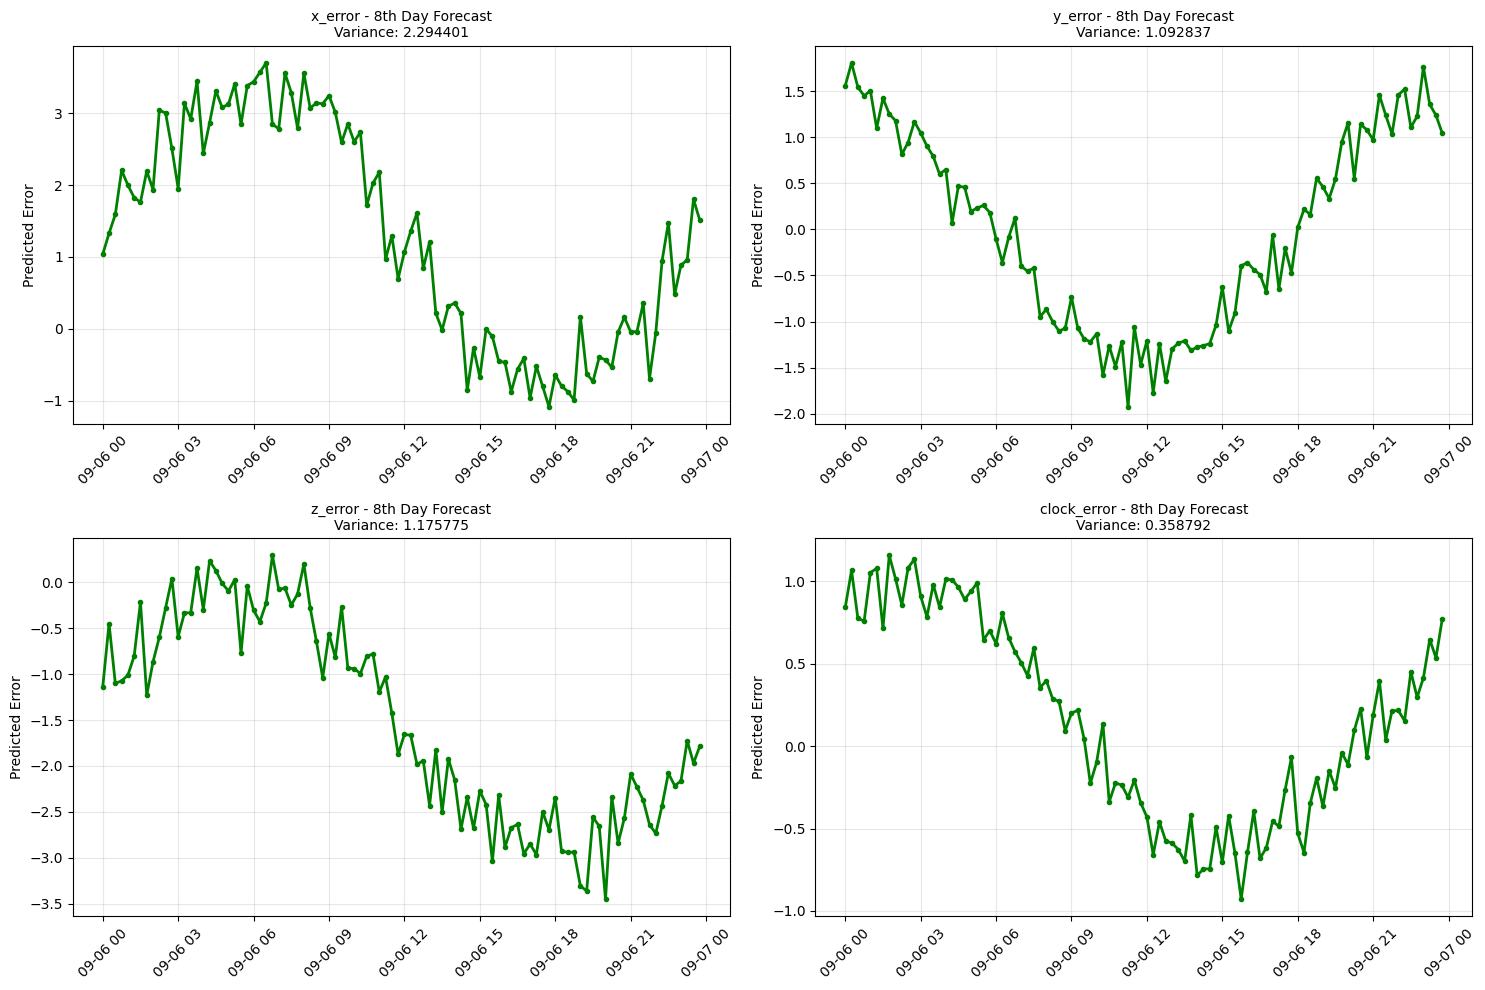

 SARIMA(1,0,1)(1,0,1,96) modeling completed successfully!


In [3]:
#  Display results
print("\n 8TH DAY PREDICTIONS (First 15 intervals)")
print("=" * 50)

# Create sample dataframe
sample_data = {}
for col in predictions_8th_day.keys():
    forecast = predictions_8th_day[col]['forecast']
    sample_data[col] = forecast.head(15).values

sample_df = pd.DataFrame(sample_data)
print(sample_df.to_string(float_format="%.4f", index=False))

print(f"\n VARIABILITY ANALYSIS:")
print("=" * 40)
for col, data in predictions_8th_day.items():
    print(f"{col:>12}: var={data['variance']:.6f}, range={data['range']:.4f}, avg_Δ={data['avg_abs_change']:.4f}")

# Step 7: Plot results
print("\n PLOTTING RESULTS")
print("=" * 40)

# Plot 2: 8th day forecasts
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(trained_models.keys()):
    forecast = predictions_8th_day[col]['forecast']

    axes[i].plot(forecast.index, forecast.values,
                color='green', linewidth=2, marker='o', markersize=3)
    axes[i].set_title(f'{col} - 8th Day Forecast\nVariance: {predictions_8th_day[col]["variance"]:.6f}', fontsize=10)
    axes[i].set_ylabel('Predicted Error')
    axes[i].grid(True, alpha=0.3)
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

print(" SARIMA(1,0,1)(1,0,1,96) modeling completed successfully!")

# **FEATURE ENGINEERING FOR XG BOOST**

STEP 0: ASSIGNING DATAFRAMES FROM YOUR COLAB NOTEBOOK
____________________________________________________________

STEP 1: VISUALIZING THE TRAIN/TEST SPLIT
____________________________________________________________


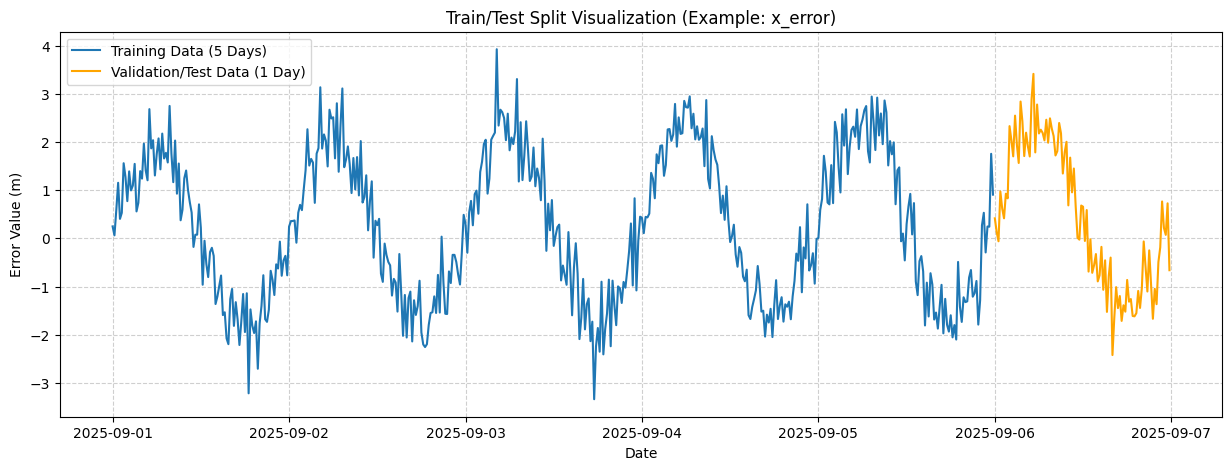


STEP 2: PERFORMING FEATURE ENGINEERING (SEPARATELY FOR TRAIN/TEST)
____________________________________________________________
Engineered training features.
Engineered testing features.

STEP 3: CREATING ALIGNED RESIDUALS AND PREDICTIONS
____________________________________________________________

STEP 4: CLEANING AND SAVING FINAL DATASETS
____________________________________________________________
Saved 'X_train_final.csv' with shape: (384, 35)
Saved 'y_train_final.csv' with shape: (384, 4)
Saved 'X_test_final.csv' with shape: (96, 35)


In [4]:
# HYBRID PIPELINE - PART 1: FEATURE ENGINEERING & DATA PREPARATION
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# --- Feature Engineering Functions ---
def create_basic_time_features(df):
    df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
    return df

def create_lag_rolling_features(df, target_col):
    lags = {'1h': 4, '6h': 24, '24h': 96}
    for name, period in lags.items():
        df[f'{target_col}_lag_{name}'] = df[target_col].shift(period)
    windows = {'6h': 24, '24h': 96}
    for name, period in windows.items():
        rolling_window = df[target_col].rolling(window=period)
        df[f'{target_col}_rolling_mean_{name}'] = rolling_window.mean()
        df[f'{target_col}_rolling_std_{name}'] = rolling_window.std()
    return df

# =============================================================================
# STEP 0: ASSIGN VARIABLES FROM YOUR COLAB NOTEBOOK
# =============================================================================
print("STEP 0: ASSIGNING DATAFRAMES FROM YOUR COLAB NOTEBOOK")
print("_" * 60)
# !!! IMPORTANT: Replace these placeholders with your actual variables !!!
# original_data = geo_augmented
# train_data = ... (your 5-day training split)
# val_data = ... (your 1-day validation/test split)
# trained_models = ... (your dictionary of fitted SARIMA models)
# -----------------------------------------------------------------------------

# FIX: Define the list of target columns explicitly here
all_targets = ['x_error', 'y_error', 'z_error', 'clock_error']



# STEP 1: VISUALIZE THE TRAIN/TEST SPLIT

print("\nSTEP 1: VISUALIZING THE TRAIN/TEST SPLIT")
print("_" * 60)
plt.figure(figsize=(15, 5))
plt.plot(train_data.index, train_data['x_error'], label='Training Data (5 Days)')
plt.plot(val_data.index, val_data['x_error'], label='Validation/Test Data (1 Day)', color='orange')
plt.title('Train/Test Split Visualization (Example: x_error)')
plt.xlabel('Date')
plt.ylabel('Error Value (m)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# STEP 2: PERFORM FEATURE ENGINEERING (LEAKAGE-FREE)
print("\nSTEP 2: PERFORMING FEATURE ENGINEERING (SEPARATELY FOR TRAIN/TEST)")
print("_" * 60)
# --- Engineer features for the TRAINING set ---
X_train = create_basic_time_features(train_data.copy())
for target in all_targets:
    X_train = create_lag_rolling_features(X_train, target)
print(f"Engineered training features.")

# --- Engineer features for the TESTING set ---
combined_for_test = pd.concat([train_data.tail(96), val_data])
X_test = create_basic_time_features(combined_for_test.copy())
for target in all_targets:
    X_test = create_lag_rolling_features(X_test, target)
X_test = X_test.loc[val_data.index]
print(f"Engineered testing features.")


# STEP 3: CREATE ALIGNED RESIDUALS AND PREDICTIONS

print("\nSTEP 3: CREATING ALIGNED RESIDUALS AND PREDICTIONS")
print("_" * 60)
# --- For Training ---
y_train_residuals = pd.DataFrame(index=train_data.index)
for target, model in trained_models.items():
    y_train_residuals[f'{target}_residual'] = model.resid

# --- For Testing ---
sarima_predictions_test = pd.DataFrame(index=val_data.index)
for target, model in trained_models.items():
    forecast = model.get_forecast(steps=len(val_data))
    sarima_predictions_test[target] = forecast.predicted_mean

# STEP 4: CLEAN AND SAVE FINAL DATASETS

print("\nSTEP 4: CLEANING AND SAVING FINAL DATASETS")
print("_" * 60)
# --- Drop rows with NaNs created by feature engineering ---
valid_train_indices = X_train.dropna().index
X_train_final = X_train.loc[valid_train_indices]
y_train_final = y_train_residuals.loc[valid_train_indices]

# --- Ensure test set columns match training set columns and clean ---
X_test_final = X_test[X_train_final.columns]
if 'orbit_type' in X_test_final.columns:
    X_test_final = X_test_final.drop(columns=['orbit_type'])
if 'orbit_type' in X_train_final.columns:
    X_train_final = X_train_final.drop(columns=['orbit_type'])

# --- Save Final Outputs ---
X_train_final.to_csv('X_train_final.csv')
y_train_final.to_csv('y_train_final.csv')
X_test_final.to_csv('X_test_final.csv')
val_data.to_csv('y_test_actuals_final.csv')
sarima_predictions_test.to_csv('sarima_predictions_test_final.csv')

print(f"Saved 'X_train_final.csv' with shape: {X_train_final.shape}")
print(f"Saved 'y_train_final.csv' with shape: {y_train_final.shape}")
print(f"Saved 'X_test_final.csv' with shape: {X_test_final.shape}")




# **XGBOOST MODEL TRANNING**

STEP 1: LOADING TRAINING DATA
------------------------------------------------------------
Training data loaded successfully.

STEP 2: TRAINING XGBOOST MODELS
------------------------------------------------------------
Training XGBoost for 'x_error' residuals...
 -> Model saved to 'xgboost_model_x_error.json'
Training XGBoost for 'y_error' residuals...
 -> Model saved to 'xgboost_model_y_error.json'
Training XGBoost for 'z_error' residuals...
 -> Model saved to 'xgboost_model_z_error.json'
Training XGBoost for 'clock_error' residuals...
 -> Model saved to 'xgboost_model_clock_error.json'

STEP 3: VISUALIZING FEATURE IMPORTANCE (EXAMPLE: x_error)
------------------------------------------------------------


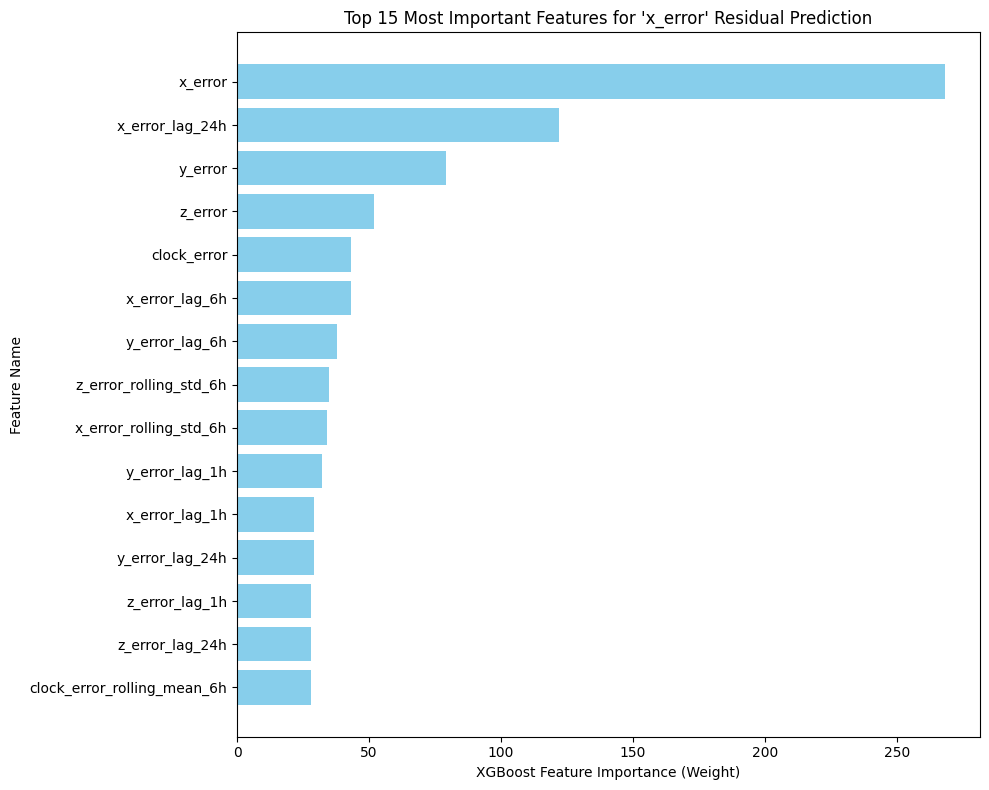

In [5]:

#TRAIN XGBOOST MODELS

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

print("STEP 1: LOADING TRAINING DATA")
print("-" * 60)
try:
    X_train = pd.read_csv('X_train_final.csv', index_col=0, parse_dates=True)
    y_train = pd.read_csv('y_train_final.csv', index_col=0, parse_dates=True)
    print("Training data loaded successfully.")
except FileNotFoundError:
    print("ERROR: Training files not found. Please run '01_feature_engineering_and_prep.py' first.")
    exit()


print("\nSTEP 2: TRAINING XGBOOST MODELS")
print("-" * 60)
all_targets = ['x_error', 'y_error', 'z_error', 'clock_error']
trained_xgboost_models = {}

for target in all_targets:
    print(f"Training XGBoost for '{target}' residuals...")
    y_target_train = y_train[f'{target}_residual']

    # Clean any potential NaNs from the target that might have slipped through
    valid_indices = y_target_train.notna()
    X_train_clean = X_train[valid_indices]
    y_target_clean = y_target_train[valid_indices]

    # Create a validation set from the training data for early stopping
    X_sub_train, X_val, y_sub_train, y_val = train_test_split(X_train_clean, y_target_clean, test_size=0.2, shuffle=False)

    # Initialize and train the XGBoost model
    xgb_model = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.25,
        max_depth=5,
        early_stopping_rounds=50,
        random_state=42
    )
    xgb_model.fit(X_sub_train, y_sub_train, eval_set=[(X_val, y_val)], verbose=False)

    # Save the trained model and store it in the dictionary
    model_filename = f'xgboost_model_{target}.json'
    xgb_model.save_model(model_filename)
    trained_xgboost_models[target] = xgb_model
    print(f" -> Model saved to '{model_filename}'")



# VISUALIZE FEATURE IMPORTANCE

print("\nSTEP 3: VISUALIZING FEATURE IMPORTANCE (EXAMPLE: x_error)")
print("-" * 60)
# Get the model for a specific target to analyze (e.g., 'x_error')
model_to_plot = trained_xgboost_models['x_error']

# Get feature importances from the trained model
importances = model_to_plot.get_booster().get_score(importance_type='weight')

# Sort the features by importance
if importances:
    sorted_importances = sorted(importances.items(), key=lambda item: item[1], reverse=True)

    # Select the top 15 features for plotting
    top_features = dict(sorted_importances[:15])
    feature_names = list(top_features.keys())
    feature_values = list(top_features.values())

    # Create the horizontal bar plot
    plt.figure(figsize=(10, 8))
    plt.barh(feature_names, feature_values, color='skyblue')
    plt.xlabel('XGBoost Feature Importance (Weight)')
    plt.ylabel('Feature Name')
    plt.title("Top 15 Most Important Features for 'x_error' Residual Prediction")
    plt.gca().invert_yaxis() # Display the most important feature at the top
    plt.tight_layout()
    plt.show()
else:
    print("Could not retrieve feature importances.")

 LOADING MODELS AND TEST DATA
------------------------------------------------------------
Models and test data loaded successfully.

 VISUALIZING XGBOOST PERFORMANCE ON RESIDUALS
------------------------------------------------------------


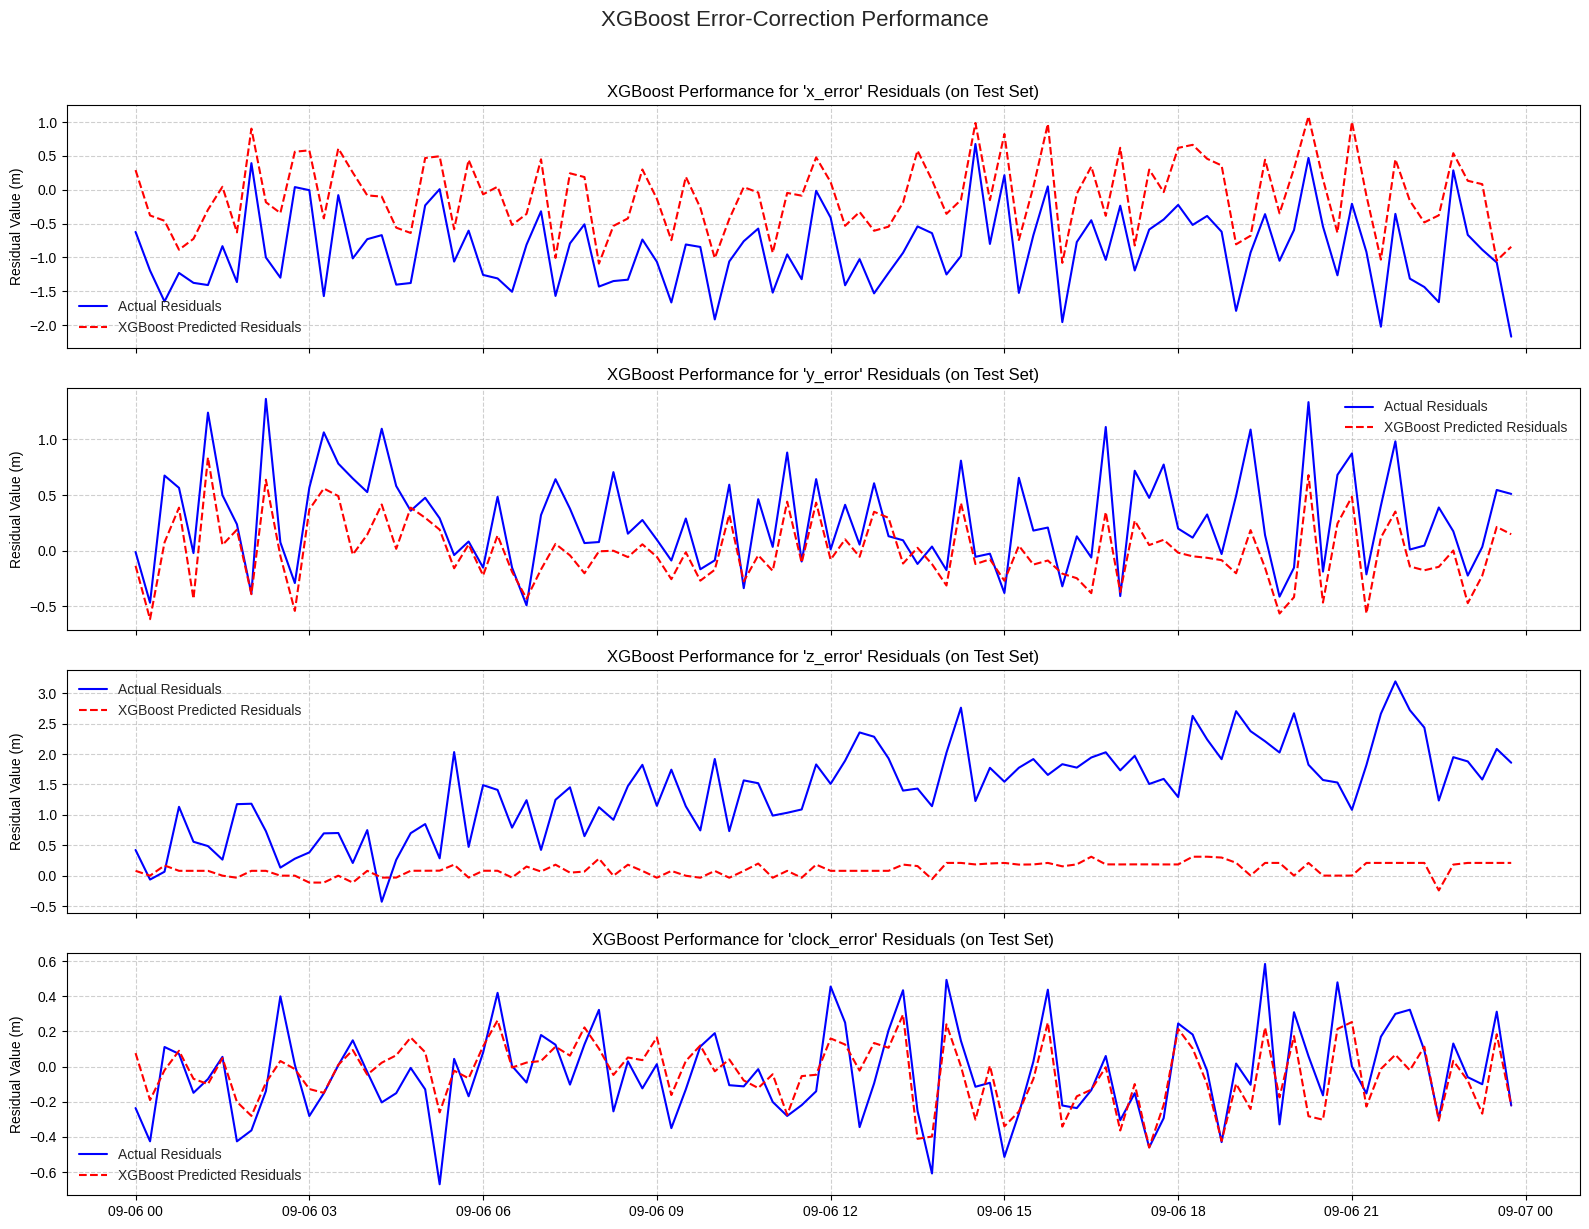

In [6]:
#  EVALUATE XGBOOST PERFORMANCE ON RESIDUALS


import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

print(" LOADING MODELS AND TEST DATA")
print("-" * 60)
try:
    X_test = pd.read_csv('X_test_final.csv', index_col=0, parse_dates=True)
    y_test_actuals = pd.read_csv('y_test_actuals_final.csv', index_col=0, parse_dates=True)
    sarima_preds_test = pd.read_csv('sarima_predictions_test_final.csv', index_col=0, parse_dates=True)

    all_targets = ['x_error', 'y_error', 'z_error', 'clock_error']
    xgboost_models = {}
    for target in all_targets:
        xgb_model = xgb.XGBRegressor()
        xgb_model.load_model(f'xgboost_model_{target}.json')
        xgboost_models[target] = xgb_model
    print("Models and test data loaded successfully.")

except FileNotFoundError as e:
    print(f"ERROR: A required file was not found: {e.name}")
    print("Please ensure you have run the previous pipeline steps first.")
    exit()

# Clean the test features just in case
X_test_clean = X_test.fillna(method='ffill').fillna(method='bfill').fillna(0)


print("\n VISUALIZING XGBOOST PERFORMANCE ON RESIDUALS")
print("-" * 60)

fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)
plt.style.use('seaborn-v0_8-whitegrid')

for i, target in enumerate(all_targets):
    # Calculate the true residuals from the test set
    actual_residuals = y_test_actuals[target] - sarima_preds_test[target]

    # Predict the residuals using the trained XGBoost model
    predicted_residuals = xgboost_models[target].predict(X_test_clean)

    # Plotting
    axes[i].plot(actual_residuals.index, actual_residuals, label='Actual Residuals', color='blue', linewidth=1.5)
    axes[i].plot(actual_residuals.index, predicted_residuals, label='XGBoost Predicted Residuals', color='red', linestyle='--', linewidth=1.5)
    axes[i].set_title(f"XGBoost Performance for '{target}' Residuals (on Test Set)")
    axes[i].set_ylabel("Residual Value (m)")
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.6)

fig.suptitle('XGBoost Error-Correction Performance', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# **FINAL HYBRID MODEL**

 LOADING MODELS AND TEST DATA
------------------------------------------------------------
Models and test data loaded successfully.

 CALCULATING PERFORMANCE METRICS
--- PERFORMANCE SUMMARY ---
             SARIMA RMSE  Hybrid RMSE  Improvement (%)
Target                                                
x_error         1.057405     0.832714        21.249237
y_error         0.511195     0.359077        29.757428
z_error         1.587960     1.467883         7.561735
clock_error     0.257078     0.162949        36.614874

 VISUALIZING FINAL HYBRID MODEL PERFORMANCE
------------------------------------------------------------


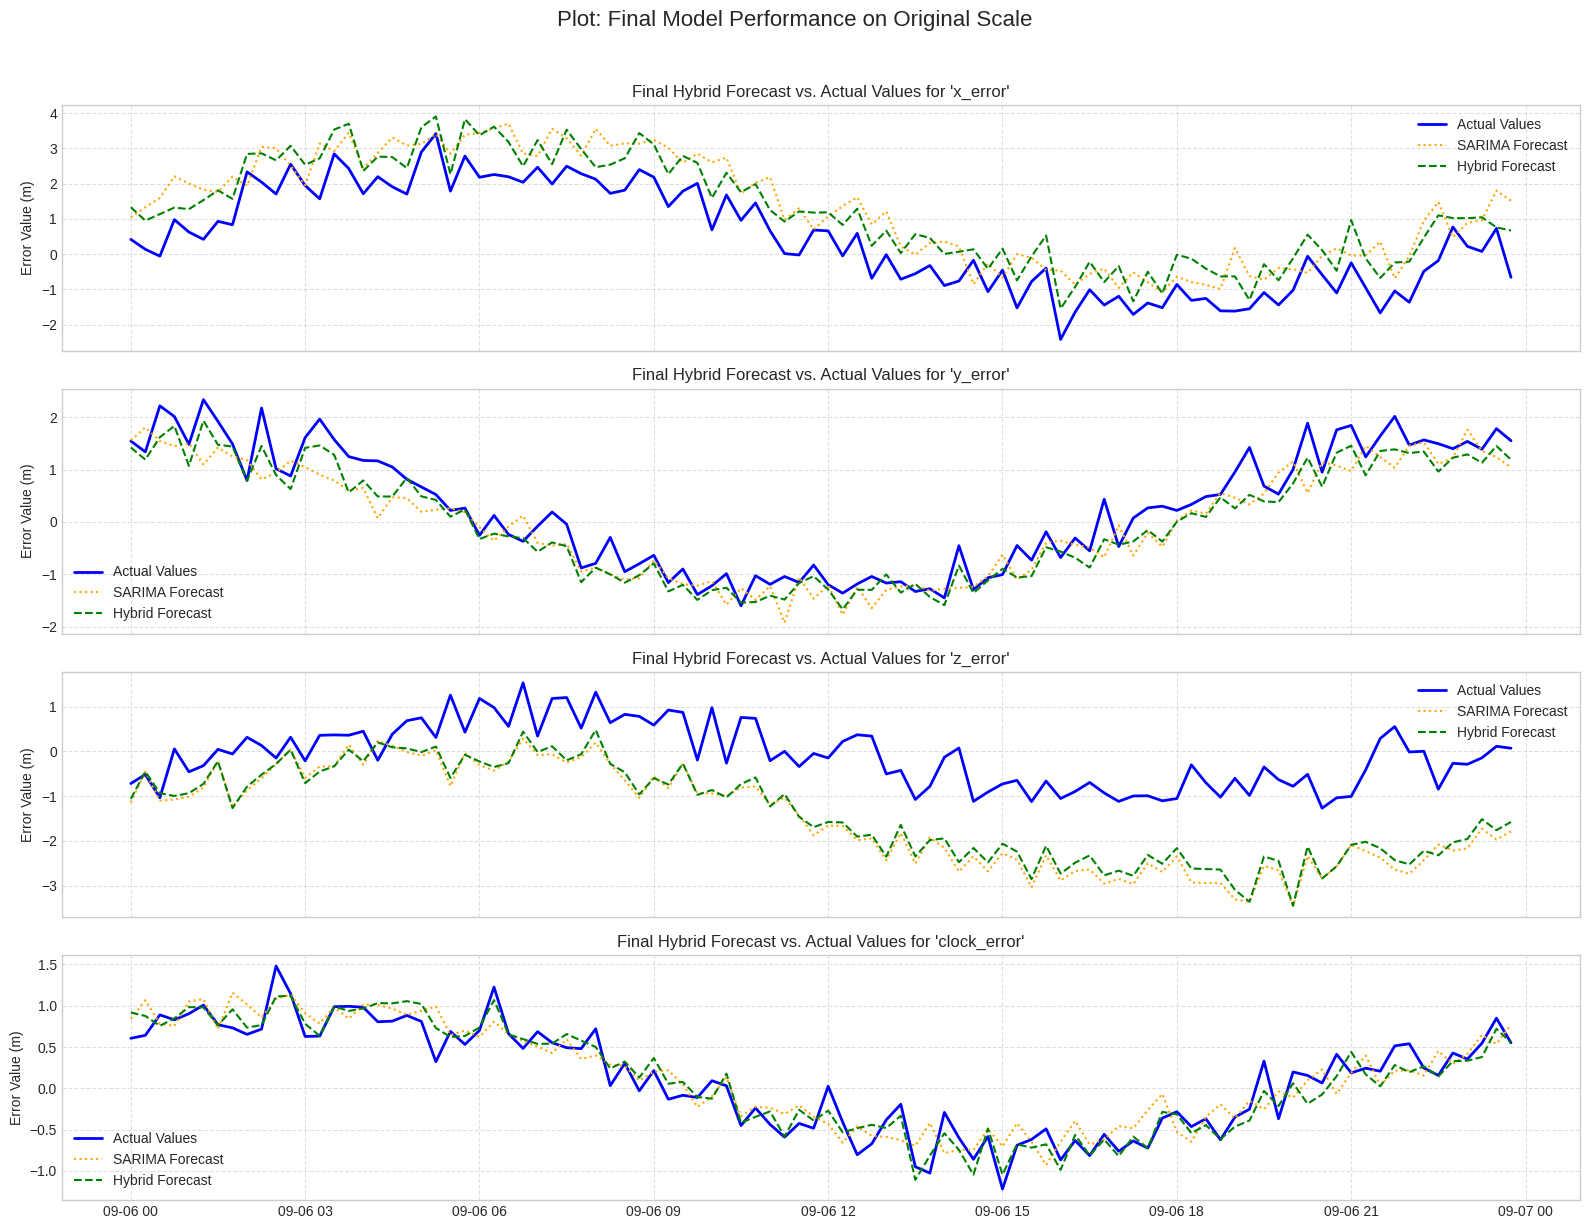

In [7]:
#  EVALUATE FINAL HYBRID MODEL


import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


print(" LOADING MODELS AND TEST DATA")
print("-" * 60)
try:
    X_test = pd.read_csv('X_test_final.csv', index_col=0, parse_dates=True)
    y_test_actuals = pd.read_csv('y_test_actuals_final.csv', index_col=0, parse_dates=True)
    sarima_preds_test = pd.read_csv('sarima_predictions_test_final.csv', index_col=0, parse_dates=True)

    all_targets = ['x_error', 'y_error', 'z_error', 'clock_error']
    xgboost_models = {}
    for target in all_targets:
        xgb_model = xgb.XGBRegressor()
        xgb_model.load_model(f'xgboost_model_{target}.json')
        xgboost_models[target] = xgb_model
    print("Models and test data loaded successfully.")

except FileNotFoundError as e:
    print(f"ERROR: A required file was not found: {e.name}")
    print("Please ensure you have run the previous pipeline steps first.")
    exit()

# Clean the test features
X_test_clean = X_test.fillna(method='ffill').fillna(method='bfill').fillna(0)


print("\n CALCULATING PERFORMANCE METRICS")
print("=" * 60)
results = []
all_hybrid_preds = pd.DataFrame(index=X_test.index)

for target in all_targets:
    # Get the base SARIMA prediction
    sarima_pred = sarima_preds_test[target]

    # Predict the residuals with XGBoost
    xgb_residual_pred = xgboost_models[target].predict(X_test_clean)

    # Create the final hybrid prediction
    hybrid_pred = sarima_pred + xgb_residual_pred
    all_hybrid_preds[target] = hybrid_pred

    # Get the actual ground-truth values
    actuals = y_test_actuals[target]

    # Calculate performance metrics
    rmse_sarima = np.sqrt(mean_squared_error(actuals, sarima_pred))
    rmse_hybrid = np.sqrt(mean_squared_error(actuals, hybrid_pred))
    improvement = ((rmse_sarima - rmse_hybrid) / rmse_sarima * 100) if rmse_sarima > 0 else 0

    results.append({
        'Target': target,
        'SARIMA RMSE': rmse_sarima,
        'Hybrid RMSE': rmse_hybrid,
        'Improvement (%)': improvement
    })

results_df = pd.DataFrame(results).set_index('Target')
print("--- PERFORMANCE SUMMARY ---")
print(results_df)


print("\n VISUALIZING FINAL HYBRID MODEL PERFORMANCE")
print("-" * 60)
fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)
plt.style.use('seaborn-v0_8-whitegrid')

for i, target in enumerate(all_targets):
    axes[i].plot(y_test_actuals.index, y_test_actuals[target], label='Actual Values', color='blue', linewidth=2)
    axes[i].plot(sarima_preds_test.index, sarima_preds_test[target], label='SARIMA Forecast', color='orange', linestyle=':', linewidth=1.5)
    axes[i].plot(all_hybrid_preds.index, all_hybrid_preds[target], label='Hybrid Forecast', color='green', linestyle='--', linewidth=1.5)
    axes[i].set_title(f"Final Hybrid Forecast vs. Actual Values for '{target}'")
    axes[i].set_ylabel("Error Value (m)")
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.6)

fig.suptitle('Plot: Final Model Performance on Original Scale', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# **FINAL 8TH DAY PERDICTIONS**

In [ ]:
#  RETRAIN AND PREDICT FINAL FORECAST

import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
import matplotlib.pyplot as plt
import warnings
from datetime import datetime, timedelta
from scipy import interpolate # Added for simple_linear_augmentation

warnings.filterwarnings('ignore')

# --- Feature Engineering Functions ---
def create_basic_time_features(df):
    df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
    return df

def create_lag_rolling_features(df, target_col):
    lags = {'1h': 4, '6h': 24, '24h': 96}
    for name, period in lags.items():
        df[f'{target_col}_lag_{name}'] = df[target_col].shift(period)
    windows = {'6h': 24, '24h': 96}
    for name, period in windows.items():
        rolling_window = df[target_col].rolling(window=period, min_periods=1)
        df[f'{target_col}_rolling_mean_{name}'] = rolling_window.mean()
        df[f'{target_col}_rolling_std_{name}'] = rolling_window.std()
    return df

# --- Functions to re-create geo_augmented if not defined ---
def verify_one_week_data(df_input): # Renamed df to df_input to avoid conflict
    print("VERIFYING ONE WEEK OF MEO DATA")
    print("=" * 50)
    # Ensure utc_time is datetime
    df_input['utc_time'] = pd.to_datetime(df_input['utc_time'], errors='coerce')
    df_input = df_input.dropna(subset=['utc_time'])

    # Check date range
    start_date = df_input['utc_time'].min().date()
    end_date = df_input['utc_time'].max().date()
    total_days = (end_date - start_date).days + 1

    print(f"Date range: {start_date} to {end_date}")
    print(f"Total days: {total_days} days")

    # Check data distribution by day
    df_input['date'] = df_input['utc_time'].dt.date
    daily_counts = df_input['date'].value_counts().sort_index()

    print(f"\n DAILY DATA DISTRIBUTION:")
    for date, count in daily_counts.items():
        print(f"  {date}: {count:3d} readings")

    # Check if we have all 7 days
    if total_days == 7:
        print(f"\n PERFECT! Found exactly 7 days of data")
        print(f"   Using ALL data for training (Days 1-7)")
        print(f"   Will predict Day 8")
    elif total_days > 7:
        print(f"\n  Found {total_days} days, but expected 7")
        print(f"   Using first 7 days for training")
        # Filter to first 7 days
        seventh_day = start_date + timedelta(days=6)
        df_input = df_input[df_input['utc_time'].dt.date <= seventh_day]
    else:
        print(f"\n Only {total_days} days found - insufficient for 7-day training")
        return None
    return df_input.drop(columns=['date']) # Drop 'date' column added for verification

def simple_linear_augmentation(df_input): # Renamed df to df_input
    print("SIMPLE LINEAR AUGMENTATION (re-creating for final prediction cell)")
    print("=" * 50)

    df_clean = df_input.copy()

    # Clean column names
    df_clean = df_clean.rename(columns={
        'x_error (m)': 'x_error',
        'y_error (m)': 'y_error',
        'z_error (m)': 'z_error',
        'satclockerror (m)': 'clock_error'
    })

    # Convert to numeric timestamps
    df_clean['timestamp'] = (df_clean['utc_time'] - df_clean['utc_time'].min()).dt.total_seconds()

    # Create target 15-minute grid within original data range
    start_time = df_clean['utc_time'].min()
    end_time = df_clean['utc_time'].max()

    full_15min_grid = pd.date_range(start=start_time.floor('15T'),
                                   end=end_time.ceil('15T'),
                                   freq='15T')

    augmented_data = pd.DataFrame({'utc_time': full_15min_grid})
    augmented_data['timestamp'] = (augmented_data['utc_time'] - start_time).dt.total_seconds()

    error_columns = ['x_error', 'y_error', 'z_error', 'clock_error']

    for col in error_columns:
        valid_mask = df_clean[col].notna()
        x_original = df_clean.loc[valid_mask, 'timestamp'].values
        y_original = df_clean.loc[valid_mask, col].values

        if len(x_original) > 1: # Ensure there are enough points for interpolation
            linear_interp = interpolate.interp1d(
                x_original, y_original,
                kind='linear',
                bounds_error=False,
                fill_value="extrapolate"
            )
            augmented_values = linear_interp(augmented_data['timestamp'].values)
            augmented_data[col] = augmented_values
        else: # If not enough points, fill with NaN and then interpolate or mean
            augmented_data[col] = np.nan
            print(f"  Warning: Not enough data points for linear interpolation in {col}. Filling with NaN.")


    augmented_data['orbit_type'] = 'GEO'
    return augmented_data.drop(columns=['timestamp']) # Drop timestamp column as it's no longer needed

print(" ASSIGNING FULL DATASET")
print("-" * 60)
# !!! IMPORTANT: Make sure the variables on the right-hand side (e.g., geo_augmented)
# !!! exist in your Colab notebook before running this script.

# Check if geo_augmented is defined, if not, re-create it
if 'geo_augmented' not in locals() and 'geo_augmented' not in globals():
    print("geo_augmented not found in current session. Re-creating it from source.")
    # Load and verify MEO data - using the path from cell DkkHsZxGJVWc or Wjvu1bFuJYH1
    # Assuming the file path is accessible and the original geo_data reading logic is sufficient
    file_path = '/content/drive/MyDrive/SIH_Data_PS-08/DATA_GEO_Train.csv' # Assuming GEO data is what's intended for 'geo_augmented'

    try:
        geo_data = pd.read_csv(file_path)
        geo_data['utc_time'] = pd.to_datetime(geo_data['utc_time'], errors='coerce')
        geo_data = geo_data.dropna(subset=['utc_time'])
        geo_training = verify_one_week_data(geo_data)
        if geo_training is not None:
            geo_augmented = simple_linear_augmentation(geo_training)
            print("geo_augmented successfully re-created.")
        else:
            raise ValueError("Insufficient data after verification to create geo_augmented.")
    except Exception as e:
        print(f"Error re-creating geo_augmented: {e}")
        # Fallback to sample data if actual data fails to load/process,
        # but warn the user. This is a safety net.
        print("Falling back to sample satellite data for final predictions due to error.")
        dates = pd.date_range('2025-09-01 00:00:00', '2025-09-07 23:45:00', freq='15T')
        np.random.seed(42)
        t = np.arange(len(dates))
        x_error = (0.1 * t/100 + 2 * np.sin(2 * np.pi * t/96) + 0.5 * np.random.normal(0, 1, len(dates)))
        y_error = (0.05 * t/100 + 1.5 * np.sin(2 * np.pi * t/96 + np.pi/2) + 0.3 * np.random.normal(0, 1, len(dates)))
        z_error = (-0.08 * t/100 + 1.2 * np.sin(2 * np.pi * t/96) + 0.8 * np.cos(2 * np.pi * t/288) + 0.4 * np.random.normal(0, 1, len(dates)))
        clock_error = (0.02 * t/100 + 0.8 * np.sin(2 * np.pi * t/96 + np.pi/4) + 0.2 * np.random.normal(0, 1, len(dates)))
        geo_augmented = pd.DataFrame({'utc_time': dates, 'x_error': x_error, 'y_error': y_error, 'z_error': z_error, 'clock_error': clock_error})
        geo_augmented = geo_augmented.set_index('utc_time') # Ensure it has a datetime index

original_data = geo_augmented
all_targets = ['x_error', 'y_error', 'z_error', 'clock_error']

# --- FIX: Ensure original_data has a DatetimeIndex ---
# This prevents the 'RangeIndex' error by converting the time column
# to the DataFrame's index if it isn't already.
if not isinstance(original_data.index, pd.DatetimeIndex):
    print("Warning: original_data does not have a DatetimeIndex. Attempting to set it.")
    # Find a potential timestamp column
    time_col = None
    if 'utc_time' in original_data.columns: # This check might be redundant if geo_augmented is always created with 'utc_time' as index or if it's already indexed by utc_time.
        time_col = 'utc_time'
    elif 'timestamp' in original_data.columns:
        time_col = 'timestamp'

    if time_col and time_col in original_data.columns: # Added check for column existence
        original_data[time_col] = pd.to_datetime(original_data[time_col])
        original_data = original_data.set_index(time_col)
        print(f"Successfully set '{time_col}' as the DatetimeIndex.")
    elif 'utc_time' in original_data.columns: # If utc_time column exists but is not index, set it
         original_data['utc_time'] = pd.to_datetime(original_data['utc_time'])
         original_data = original_data.set_index('utc_time')
         print(f"Successfully set 'utc_time' as the DatetimeIndex.")
    else:
        # If no explicit time column found or it's already indexed by datetime (likely for geo_augmented)
        # This part of the code should ideally not be reached if geo_augmented is correctly formed.
        print("Could not find a suitable timestamp column to set as index, assuming DataFrame is already time-indexed or handling later.")
        # Re-verify if index is DatetimeIndex, raise error if not
        if not isinstance(original_data.index, pd.DatetimeIndex):
            raise ValueError("original_data must have a DatetimeIndex to proceed.")
# --- End of Fix ---

original_data = original_data.sort_index()


print("\nRETRAINING MODELS ON FULL 7-DAY DATASET")
print("-" * 60)
# --- Retrain SARIMA ---
full_sarima_models = {}
full_residuals = pd.DataFrame(index=original_data.index)
for target in all_targets:
    # Check if target column exists in original_data
    if target not in original_data.columns:
        print(f"Warning: Target column '{target}' not found in original_data. Skipping SARIMA for this target.")
        continue # Skip to the next target

    model = SARIMAX(original_data[target], order=(1, 1, 1), seasonal_order=(1, 1, 1, 96)).fit(disp=False)
    full_sarima_models[target] = model
    full_residuals[f'{target}_residual'] = model.resid

# --- Create Full Feature Set ---
X_full = create_basic_time_features(original_data.copy())
for target in all_targets:
    X_full = create_lag_rolling_features(X_full, target)
if 'orbit_type' in X_full.columns:
    X_full = X_full.drop(columns=['orbit_type'])

# --- Retrain XGBoost ---
final_xgboost_models = {}
for target in all_targets:
    if f'{target}_residual' not in full_residuals.columns: # Check if residual was created
        print(f"Warning: Residuals for '{target}' not found. Skipping XGBoost for this target.")
        continue

    y_target = full_residuals[f'{target}_residual']
    valid_indices = y_target.notna() & X_full.notna().all(axis=1) # Ensure X_full has enough rows after creating lags
    X_clean = X_full[valid_indices]
    y_clean = y_target[valid_indices]

    if X_clean.empty or y_clean.empty:
        print(f"Warning: No valid data to train XGBoost for '{target}' after cleaning. Skipping.")
        continue

    xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42)
    xgb_model.fit(X_clean, y_clean)
    final_xgboost_models[target] = xgb_model

print("\n GENERATING 8TH DAY FORECAST")
print("-" * 60)
forecast_steps = 96
last_ts = original_data.index.max()
future_index = pd.date_range(start=last_ts + pd.Timedelta(minutes=15), periods=forecast_steps, freq='15T')

# --- SARIMA Base Forecast ---
sarima_forecast = pd.DataFrame(index=future_index)
for target, model in full_sarima_models.items():
    sarima_forecast[target] = model.get_forecast(steps=forecast_steps).predicted_mean

# --- Features for Future Period ---
combined_for_future = pd.concat([original_data, sarima_forecast])
X_future = create_basic_time_features(combined_for_future.copy())
for target in all_targets:
    X_future = create_lag_rolling_features(X_future, target)
X_future = X_future.loc[future_index]
if 'orbit_type' in X_future.columns:
    X_future = X_future.drop(columns=['orbit_type'])

# Align columns before cleaning, using the cleaned training set columns
# X_clean columns are from the XGBoost training phase
# Need to make sure X_future_clean has the same columns as X_clean
if not final_xgboost_models:
    raise RuntimeError("No XGBoost models were trained. Cannot generate future forecast.")
# Pick one model to get column names from X_clean
first_target_with_model = next(iter(final_xgboost_models.keys()))
# Re-create X_clean based on the full data's X_full to get correct column order/set
y_target_temp = full_residuals[f'{first_target_with_model}_residual']
valid_indices_temp = y_target_temp.notna() & X_full.notna().all(axis=1)
X_clean_ref = X_full[valid_indices_temp]

# Ensure X_future has only columns present in X_clean_ref
missing_cols_in_future = set(X_clean_ref.columns) - set(X_future.columns)
for col in missing_cols_in_future:
    X_future[col] = 0 # Add missing columns, fill with 0 or appropriate default
X_future = X_future[X_clean_ref.columns] # Reorder to match X_clean_ref
X_future_clean = X_future.fillna(method='ffill').fillna(method='bfill').fillna(0)


# --- XGBoost Residual Forecast ---
xgb_residual_forecast = pd.DataFrame(index=future_index)
for target, model in final_xgboost_models.items():
    if target not in sarima_forecast.columns: # Skip if SARIMA didn't run for this target
        continue
    xgb_residual_forecast[target] = model.predict(X_future_clean)

# --- Final Hybrid Forecast ---
hybrid_forecast = sarima_forecast + xgb_residual_forecast

print("\nSAVING AND DISPLAYING FORECAST")
print("=" * 60)
hybrid_forecast.to_csv('future_forecast_final.csv')
print("Forecast saved to 'future_forecast_final.csv'")
print(hybrid_forecast.head(10))


print("\n VISUALIZING THE FINAL 24-HOUR FORECAST")
print("-" * 60)
fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)
for i, target in enumerate(all_targets):
    if target not in hybrid_forecast.columns:
        axes[i].set_title(f"No Forecast for '{target}' available")
        continue

    axes[i].plot(hybrid_forecast.index, hybrid_forecast[target], label='Hybrid Forecast (Next 24h)', color='green', marker='.')
    axes[i].set_title(f"Final 24-Hour Forecast for '{target}'")
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

 ASSIGNING FULL DATASET
------------------------------------------------------------
geo_augmented not found in current session. Re-creating it from source.
Error re-creating geo_augmented: [Errno 2] No such file or directory: '/content/drive/MyDrive/SIH_Data_PS-08/DATA_GEO_Train.csv'
Falling back to sample satellite data for final predictions due to error.

RETRAINING MODELS ON FULL 7-DAY DATASET
------------------------------------------------------------
